#### Install dependencies

In [1]:
%pip install -U openmim
!mim install mmcv-full

# install mmpose dependencies
%pip install -v -r requirements.txt

%pip install mmdet
%pip install mmpose
# install mmpose in develop mode
%pip install -v -e .

In [5]:
%run setup_env.py

### 2D

#### Extract all AcinoSet 2D Labelled data: COCO format

In [ ]:
# NB: unzip "labelled_data.zip" to "/notebooks/data/acino/labelled" first

acino='/notebooks/data/acino'

img_ids=[os.path.splitext(img)[0] for img in os.listdir(acino+'/../ap10k/data/')]
img_ids.remove('.ipynb_checkpoints')
img_ids=[int(i) for i in img_ids]
img_no=max(img_ids)+1

base=pd.read_csv('base.csv')

for dir in os.listdir(acino+'/labelled'): #JamesFlick1 JamesFlick2 etc.
    print(dir)
    if os.path.isdir(acino+'/labelled/'+dir):
        
        df=pd.read_csv('labelled/'+dir+'/'+"CollectedData_UCT.csv")

        df.iloc[0,1:]=df.iloc[0,1:].astype(str) +'_'+ df.iloc[1,1:].astype(str)
        df.columns=df.iloc[0] # Make keypoint labels column headers
        df=df.iloc[2:,:]
        
        #Extract COCO keypoints (AP10K):
        #df=df.reindex(columns=(['bodyparts','l_eye_x','l_eye_y','r_eye_x','r_eye_y','nose_x','nose_y','neck_base_x','neck_base_y','tail_base_x','tail_base_y','l_shoulder_x','l_shoulder_y','l_front_knee_x','l_front_knee_y','l_front_paw_x','l_front_paw_y','r_shoulder_x','r_shoulder_y','r_front_knee_x','r_front_knee_y','r_front_paw_x','r_front_paw_y','l_hip_x','l_hip_y','l_back_knee_x','l_back_knee_y','l_back_paw_x','l_back_paw_y','r_hip_x','r_hip_y','r_back_knee_x','r_back_knee_y','r_back_paw_x','r_back_paw_y','tail2_x','tail2_y']))
        
        #Extract COCO keypoints (All Acino Keypoints):
        df=df.reindex(columns=(['bodyparts','l_eye_x','l_eye_y','r_eye_x','r_eye_y','nose_x','nose_y','neck_base_x','neck_base_y','tail_base_x','tail_base_y','l_shoulder_x','l_shoulder_y','l_front_knee_x','l_front_knee_y','l_front_paw_x','l_front_paw_y','r_shoulder_x','r_shoulder_y','r_front_knee_x','r_front_knee_y','r_front_paw_x','r_front_paw_y','l_hip_x','l_hip_y','l_back_knee_x','l_back_knee_y','l_back_paw_x','l_back_paw_y','r_hip_x','r_hip_y','r_back_knee_x','r_back_knee_y','r_back_paw_x','r_back_paw_y','tail2_x','tail2_y','tail1_x','tail1_y','r_front_ankle_x','r_front_ankle_y','l_front_ankle_x','l_front_ankle_y','r_back_ankle_x','r_back_ankle_y','l_back_ankle_x','l_back_ankle_y','spine_x','spine_y']))
        
        for i in range(0,len(df)): # Iterate over rows
            orig=df.iloc[i,0].split('/')[2]
            df.iloc[i,0]='as_'+str(img_no)+'.jpg'
            
            im=Image.open('data/acino/labelled/'+dir+'/'+orig)
            img_name='as_'+str(img_no)
            im.save('data/acino/data/'+img_name+'.jpg')
            
            #os.remove('labelled1/'+dir+'/'+orig)
            
            
            img_no+=1
        base=pd.concat([base,df[0:]],ignore_index=True)
               
base.to_csv("data/acino/annotations.csv",index=False)

In [ ]:
df = pd.read_csv('data/acino/annotations.csv')

if os.path.exists("data/acino/annotations/acino_all.json"):
    os.remove("data/acino/annotations/acino_all.json")
    
shutil.copyfile('data/acino/annotations/anns_empty_acino.json','data/acino/annotations/acino_all.json')

with open('data/acino/annotations/acino_all.json','r+') as f: # Save all annotation instances in one .json file
    anns_data=json.load(f)
    
    for i in range(0,len(df)):# Iterate over each image

        #Add image instance
        img_name=df.iloc[i,0]
        img_id=int(img_name[3:].split('.')[0])
        img=cv2.imread('data/acino/data/'+img_name)
        height = img.shape[0]
        width = img.shape[1]
        img_inst=dict(width=width,height=height,file_name=img_name,background=1,id=img_id)
        
        #Add annotation instance
        ann_id=img_id
        kp=[]
        num_kp=0

        # Initial bbox:
        x_min=width-1
        x_max=1
        y_min=height-1
        y_max=1

        for j in range(1,len(df.columns),2): # -12 for AP10k format
            if pd.isnull(df.iloc[i,j]): #NaN values
                kp.append(0)
                kp.append(0)
                kp.append(0)
                
            else:
                x=int(round(pd.to_numeric(df.iloc[i,j])))
                y=int(round(pd.to_numeric(df.iloc[i,j+1])))
                
                #Add annotations
                kp.append(x)
                kp.append(y)
                kp.append(2)
                num_kp+=1

                #Bbox
                if x<x_min:
                    x_min=x
                if x>x_max:
                    x_max=x
                if y>y_max:
                    y_max=y
                if y<y_min:
                    y_min=y
                    
        # Pad bbox with extra pixels:
        x_min=x_min-15
        y_min=y_min-15
        
        # BBox w, h
        w=max(1,(x_max-x_min))+30
        h=max(1,(y_max-y_min))+30
        a=w*h # Bbox area
        
        #Padded bounding box:
        bbox=[x_min,y_min,w,h] # xywh format NB! y_min==top left corner
        
        # Uncomment for AP10k format:
        
#         if kp[-1]==2: # If tip of tail != NaN
#             num_kp-=1 
            
#         del kp[-3:] # Remove tail_x, tail_y, visible
        
        
        ann_inst=dict(image_id=img_id,iscrowd=0,category_id=1,num_keypoints=num_kp,keypoints=kp,bbox=bbox,id=ann_id,area=a)
        anns_data['images'].append(img_inst)
        anns_data['annotations'].append(ann_inst)
    f.seek(0)
    json.dump(anns_data,f,indent=4)
f.close()

In [ ]:
%pip install echo1-coco-split

!coco-split --annotations_file data/acino/annotations/acino_all.json --valid_ratio 0.1 --test_ratio 0.2 --train_name data/acino/annotations/acino_train.json --valid_name data/acino/annotations/acino_val.json --test_name data/acino/annotations/acino_test.json --has_annotations

#### Train, test and demo 2D pose estimator

##### Config file:

In [4]:
cfg = Config.fromfile('configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/acino/res50_acino_256x256.py')
# print(cfg.work_dir)
# train_from_config(cfg,True)
test_pose_estimator('work_dirs/res50_acino_256x256',cfg,False)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
=> num_images: 1528
=> load 1510 samples
load checkpoint from local path: work_dirs/res50_acino_256x256/latest.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1510/1510, 88.9 task/s, elapsed: 17s, ETA:     0sLoading and preparing results...
DONE (t=0.07s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.43s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.678
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.980
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.792
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.517
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.693
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.719
 Average Recall     

In [10]:
# Config file:
cfg = Config.fromfile('configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/acino/res50_acino_256x256.py')
# print(cfg.work_dir)
# train_from_config(cfg,True)
test_pose_estimator('work_dirs/res50_acino_256x256',cfg,False)
# cfg.lr_config

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
=> num_images: 1528
=> load 1510 samples
load checkpoint from local path: work_dirs/res50_acino_256x256/latest.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1510/1510, 97.5 task/s, elapsed: 15s, ETA:     0sLoading and preparing results...
DONE (t=0.08s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.48s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.678
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.980
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.792
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.517
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.693
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.719
 Average Recall     

In [12]:
train=np.load('data/acino_3d/annotations/FTE/acino3d_train.npz')
len

##### Train model from cfg: 

In [2]:
# Train from config file
def train_from_config(cfg,pretr=True):
    if pretr==False:
        cfg.model['pretrained']=None
    elif pretr==True:
        cfg.work_dir=cfg.work_dir+'_pretr'
        
    mmcv.mkdir_or_exist(cfg.work_dir)
    cfg.log_name = time.strftime('%d-%m-', time.localtime())+"ep"+str(cfg.total_epochs)
    cfg.log_file = os.path.join(cfg.work_dir, f'{cfg.log_name}.log')
    
    autoscale_lr = False # automatically scale lr with the number of gpus
    launcher = 'none' # Job launcher. ['none', 'pytorch', 'slurm', 'mpi']
    deterministic = False # Whether to set deterministic options for CUDNN backend.
    diff_seed = False # Whether or not set different seeds for different ranks
    seed = 0 

    if autoscale_lr:
        # apply the linear scaling rule (https://arxiv.org/abs/1706.02677)
        cfg.optimizer['lr'] = cfg.optimizer['lr'] * len(cfg.gpu_ids) / 8

    if launcher == 'none':
        distributed = False
        if len(cfg.gpu_ids) > 1:
            warnings.warn(
                f'We treat {cfg.gpu_ids} as gpu-ids, and reset to '
                f'{cfg.gpu_ids[0:1]} as gpu-ids to avoid potential error in '
                'non-distribute training time.')
            cfg.gpu_ids = cfg.gpu_ids[0:1]
    else:
        distributed = True
        init_dist(launcher, **cfg.dist_params)
        # re-set gpu_ids with distributed training mode
        _, world_size = get_dist_info()
        cfg.gpu_ids = range(world_size)

    # set multi-process settings
    setup_multi_processes(cfg)

    # init the logger before other steps
    logger = get_root_logger(log_file=cfg.log_file, log_level=cfg.log_level)

    # init the meta dict to record some important information such as
    # environment info and seed, which will be logged
    meta = dict()

    # log env info
    env_info_dict = collect_env()
    env_info = '\n'.join([(f'{k}: {v}') for k, v in env_info_dict.items()])
    dash_line = '-' * 60 + '\n'
    # logger.info('Environment info:\n' + dash_line + env_info + '\n' +
    #             dash_line)
    meta['env_info'] = env_info

    # log some basic info
    logger.info(f'Distributed training: {distributed}')
    # logger.info(f'Config:\n{cfg.pretty_text}')

    # set random seeds
    seed = init_random_seed(seed)
    seed = seed + dist.get_rank() if diff_seed else seed
    logger.info(f'Set random seed to {seed}, '
                f'deterministic: {deterministic}')
    set_random_seed(seed, deterministic=deterministic)
    cfg.seed = seed
    meta['seed'] = seed

    # build dataset
    train_set = [build_dataset(cfg.data.train)]

    # build model
    model = build_posenet(cfg.model)

    if len(cfg.workflow) == 2:
        val_dataset = copy.deepcopy(cfg.data.val)
        val_dataset.pipeline = cfg.data.train.pipeline
        train_set.append(build_dataset(val_dataset))

    if cfg.checkpoint_config is not None:
        # save mmpose version, config file content
        # checkpoints as meta data
        cfg.checkpoint_config.meta = dict(
            mmpose_version=__version__ + get_git_hash(digits=7),
            # config=cfg.pretty_text,
        )

    timestamp = time.strftime('%d-%m-', time.localtime())+"ep"+str(cfg.total_epochs)

    # train model
    train_model(
        model,
        train_set, 
        cfg, 
        distributed=distributed, 
        validate=True, 
        timestamp=timestamp,
        meta=meta)
    
def test_pose_estimator(ckpt,cfg):

    # set multi-process settings
    setup_multi_processes(cfg)

    # set cudnn_benchmark
    if cfg.get('cudnn_benchmark', False):
        torch.backends.cudnn.benchmark = True
    cfg.model.pretrained = None
    cfg.data.test.test_mode = True

    distributed = False

    # build the dataloader
    dataset = build_dataset(cfg.data.test, dict(test_mode=True))
    # step 1: give default values and override (if exist) from cfg.data
    loader_cfg = {
        **dict(seed=cfg.get('seed'), drop_last=False, dist=distributed),
        **({} if torch.__version__ != 'parrots' else dict(
               prefetch_num=2,
               pin_memory=False,
           )),
        **dict((k, cfg.data[k]) for k in [
                   'seed',
                   'prefetch_num',
                   'pin_memory',
                   'persistent_workers',
               ] if k in cfg.data)
    }
    # step2: cfg.data.test_dataloader has higher priority
    test_loader_cfg = {
        **loader_cfg,
        **dict(shuffle=False, drop_last=False),
        **dict(workers_per_gpu=cfg.data.get('workers_per_gpu', 1)),
        **dict(samples_per_gpu=cfg.data.get('samples_per_gpu', 1)),
        **cfg.data.get('test_dataloader', {})
    }
    
    data_loader = build_dataloader(dataset, **test_loader_cfg)

    # build the model and load checkpoint
    model = build_posenet(cfg.model)
    fp16_cfg = cfg.get('fp16', None)
    if fp16_cfg is not None:
        wrap_fp16_model(model)
    load_checkpoint(model, ckpt, map_location='cpu')
    model = fuse_conv_bn(model)

    if not distributed:
        model = MMDataParallel(model, device_ids=[0])
        outputs = single_gpu_test(model, data_loader)

    rank, _ = get_dist_info()
    eval_config = cfg.get('evaluation', {})

    results = dataset.evaluate(outputs, cfg.work_dir, **eval_config)
    for k, v in sorted(results.items()):
        print(f'{k}: {v}')

##### 2D Estimator inference, analysis:

In [ ]:
# Test model:

pose_checkpoint = cfg.work_dir+'/latest.pth'
json_file_gt='data/acino/annotations/acino_all.json'

# with open('./work_dirs/hrnet_w32_acino-10k_256x256_epoch50/result_keypoints.json','r') as f: 
#     json_file_pred=json.load(f)
# f.close()

# print()

coco = COCO(json_file_gt)
# print(coco)
img_keys = list(coco.imgs.keys())
# print(img_keys)
# # initialize pose model
pose_model = init_pose_model(cfg, pose_checkpoint)
dataset = pose_model.cfg.data.test.type
dataset_info = pose_model.cfg.data.test.get('dataset_info', None)
dataset_info = DatasetInfo(dataset_info)
return_heatmap=True
output_layer_names=None

n=1 # Num imgs to plot
ntest=len(img_keys)
show= np.random.choice(ntest,n)

#GT:
for i in range(n):
    img_id=img_keys[show[i]]
    image=coco.loadImgs(img_id)[0]
    img_name=os.path.join('data/acino/data',image['file_name'])
    
    # pred=next(inst for inst in json_file_pred if inst['image_id']==img_id)
    
    
    ann_ids=coco.getAnnIds(img_id)
    # print(ann_ids)
    ann=coco.anns[ann_ids[0]]
    # print(ann)
    animal_bbox=[]
    gt_keypoints=[]
    
    for ann_id in ann_ids:
        animal={}  
        ann=coco.anns[ann_id]
        animal['bbox']=ann['bbox']
        animal_bbox.append(animal)
        
        gt={}
        x=ann['bbox'][0]
        y=ann['bbox'][1]
        w=ann['bbox'][2]
        h=ann['bbox'][3]
        gt['bbox']=[x,y,x+w,y+h]
        gt['keypoints']=np.array(ann['keypoints']).reshape(24,3)
        gt_keypoints.append(gt)
    
    # x=ann['bbox'][0]
    # y=ann['bbox'][1]
    # w=ann['bbox'][2]
    # h=ann['bbox'][3]
#     print(ann['bbox'])
    # bbox=[x,y,x+w,y+h]
    
#     print(ann['bbox'])

    pose_results, returned_outputs = inference_top_down_pose_model(
        pose_model,
        img_name,
        person_results=animal_bbox, # BBoxs required for top down
        bbox_thr=None,
        format='xywh',
        dataset=dataset,
        dataset_info=dataset_info,
        return_heatmap=True, #for now
        outputs=output_layer_names)
    
    out_file_pred = os.path.join('vis_result', f'vis_as{img_id}.jpg')
    out_file_gt = os.path.join('vis_result', f'vis_gt_as{img_id}.jpg')
    vis_result_pred=vis_pose_result(pose_model,img_name,pose_results,radius=3,thickness=1,out_file=out_file_pred)
    # vis_result_pred = cv2.resize(vis_result_pred, dsize=None, fx=1.5, fy=1.5)
    
    vis_result_gt=vis_pose_result(pose_model,img_name,gt_keypoints,radius=3,thickness=1,out_file=out_file_gt)
    # vis_result_gt = cv2.resize(vis_result_gt, dsize=None, fx=1.5, fy=1.5)
    # vis_result_gt = vis_result_gt

    plt.figure(figsize=(15,10))
    plt.imshow(vis_result_gt[y-25:y+h+25,x-25:x+w+25])
    plt.show()
    
    plt.figure(figsize=(15,10))
    plt.imshow(vis_result_pred[y-25:y+h+50,x-25:x+w+50])
    plt.show()
    
#     os.makedirs('vis_result', exist_ok=True)
#     out_file = os.path.join('vis_result', f'vis_as{image_id}.jpg')
#     vis_result=vis_pose_result(pose_model,image_name,pose_results,radius=3,thickness=1,out_file=out_file)
#     vis_result = cv2.resize(vis_result, dsize=None, fx=1.5, fy=1.5)
#     # plt.figure(figsize=(15,10))
#     # plt.imshow(vis_result)
#     # plt.show()
    


In [ ]:
!python tools/analysis/analyze_logs.py \
        plot_curve work_dirs/hrnet_w32_acino_256x256_epoch50/None.log.json \
        --keys acc_pose \
        --legend Accuracy \
        --out acino_accuracy.jpg

##### 2D Estimator demo with MMDet

In [45]:
det_config='MMDet/retinanet_r50_fpn_2x_acino/retinanet_r50_fpn_2x_acino.py'
det_checkpoint='MMDet/retinanet_r50_fpn_2x_acino/epoch_10.pth'

pose_config='configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/acino/res152_acino_256x256.py'
pose_checkpoint='work_dirs/res152_acino_256x256_pretr/epoch_80.pth'

vid='vis_results/lily39cam2.mp4'#'../storage/cam3.mp4'
# out_vid='vis_results'

In [46]:
det_config='MMDet/retinanet_r50_fpn_2x_acino/retinanet_r50_fpn_2x_acino.py'
det_checkpoint='MMDet/retinanet_r50_fpn_2x_acino/epoch_10.pth'

pose_config='configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/acino/res152_acino_256x256.py'
pose_checkpoint='work_dirs/res152_acino_256x256_pretr/epoch_80.pth'

vid='vis_results/lily39cam2.mp4'
topdown_mmtrack(det_config,det_checkpoint,pose_config,pose_checkpoint,vid)

Initializing model...
load checkpoint from local path: MMDet/retinanet_r50_fpn_2x_acino/epoch_10.pth
load checkpoint from local path: work_dirs/res152_acino_256x256_pretr/epoch_80.pth
Running inference...
[>>>>                            ] 31/219, 4.3 task/s, elapsed: 7s, ETA:    44s

KeyboardInterrupt: 

### 3D

#### Extract all AcinoSet 3D data

In [137]:
# kp2d_res[:,:,2:]
x=np.load('data/acino_3d/annotations/Res50/acino3d_train.npz')
np.reshape(x['part'][:,:,2:],(20,10975))[:,0]


array([0.92301565, 0.87193483, 0.91597664, 0.93954647, 0.87893677,
       0.55683208, 0.89322901, 1.        , 0.81639624, 0.00404445,
       0.91083425, 0.29521003, 0.        , 0.20737392, 0.79919231,
       0.9138338 , 0.71784186, 0.74440837, 0.88070983, 0.89076483])

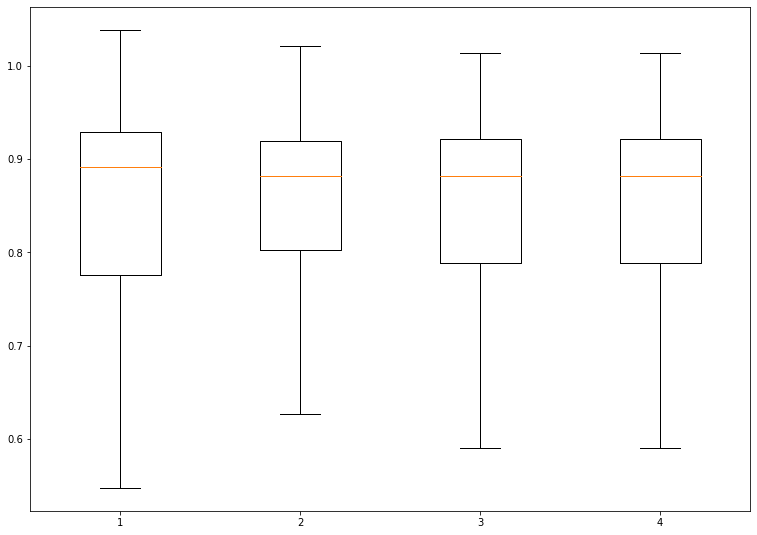

In [146]:
nose=x['part'][:,:,2:][:,0].flatten()
reye=x['part'][:,:,2:][:,1].flatten()
leye=x['part'][:,:,2:][:,2].flatten()
neck=x['part'][:,:,2:][:,3].flatten()
spine=x['part'][:,:,2:][:,4].flatten()
tail_root=x['part'][:,:,2:][:,5].flatten()
tail_mid=x['part'][:,:,2:][:,6].flatten()
tail_tip=x['part'][:,:,2:][:,7].flatten()
r_shoulder=x['part'][:,:,2:][:,8].flatten()
r_f_knee=x['part'][:,:,2:][:,9].flatten()
r_f_ankle=x['part'][:,:,2:][:,10].flatten()
l_shoulder=x['part'][:,:,2:][:,11].flatten()
l_f_knee=x['part'][:,:,2:][:,12].flatten()
l_f_ankle=x['part'][:,:,2:][:,13].flatten()
r_hip=x['part'][:,:,2:][:,14].flatten()
r_b_knee=x['part'][:,:,2:][:,15].flatten()
r_b_ankle=x['part'][:,:,2:][:,16].flatten()
l_hip=x['part'][:,:,2:][:,17].flatten()
l_b_knee=x['part'][:,:,2:][:,18].flatten()
l_b_ankle=x['part'][:,:,2:][:,19].flatten()


fig = plt.figure(figsize =(10, 7))

# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot([nose,reye,leye,neck,spine,tail_root,tail_mid,tail_tip,r_shoulder,],showfliers=False)
 
# show plot
plt.savefig('pls.png')

In [138]:
x['part'][:,:,2:][

array([[[0.92301565],
        [0.84420121],
        [0.89163518],
        ...,
        [0.07884105],
        [0.17977941],
        [0.01440887]],

       [[0.94347513],
        [0.81407607],
        [0.86851323],
        ...,
        [0.67418993],
        [0.4587321 ],
        [0.01955197]],

       [[0.94558746],
        [0.83171815],
        [0.89047617],
        ...,
        [0.79611719],
        [0.57446015],
        [0.08767438]],

       ...,

       [[0.94113564],
        [0.88042891],
        [0.9425686 ],
        ...,
        [0.85478264],
        [0.87018901],
        [0.91807115]],

       [[0.93210304],
        [0.86157119],
        [0.90656149],
        ...,
        [0.83160573],
        [0.87984538],
        [0.92381102]],

       [[0.94161129],
        [0.87771332],
        [0.9161979 ],
        ...,
        [0.87718976],
        [0.88311553],
        [0.89931089]]])

In [59]:
det_config='MMDet/retinanet_r50_fpn_2x_acino/retinanet_r50_fpn_2x_acino.py'
det_checkpoint='MMDet/retinanet_r50_fpn_2x_acino/epoch_10.pth'

pose_config='configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/acino/res152_acino_256x256.py'
pose_checkpoint='work_dirs/res152_acino_256x256_pretr/epoch_80.pth'

det_model=init_detector(det_config,
                        det_checkpoint)

pose_model=init_pose_model(pose_config,
                           pose_checkpoint)
pose_dataset=pose_model.cfg.data['test']['type']
pose_dataset_info = pose_model.cfg.data['test'].get('dataset_info', None)
pose_dataset_info=DatasetInfo(pose_dataset_info)
smoother = Smoother(filter_cfg='configs/_base_/filters/one_euro.py', keypoint_dim=2)
imgnames,centers_res,scales_res,kp2d_res,kp3d,centers_fte,scales_fte,kp2d_fte=get_anns('2019030502','jules','run','cam2.mp4','2019_03_05',57,176,pose_model,det_model,smoother)

load checkpoint from local path: MMDet/retinanet_r50_fpn_2x_acino/epoch_10.pth
load checkpoint from local path: work_dirs/res152_acino_256x256_pretr/epoch_80.pth
[>>>>>>                         ] 57/261, 80.6 task/s, elapsed: 1s, ETA:     3s

/usr/local/lib/python3.9/dist-packages/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 261/261, 3.5 task/s, elapsed: 74s, ETA:     0s


##### Extract and process 2D and 3D annotations

In [5]:
#Cameras
cameras={}
for date in os.listdir('data/acino_3d'):
    if date.split('_')[0]=='2019':
        #Cameras
        if osp.exists(f'data/acino_3d/{date}/extrinsic_calib/6_cam_scene.json'):
            calib=f'data/acino_3d/{date}/extrinsic_calib/6_cam_scene.json'
            n=6 # cam scene
            add_cameras(n,calib,cameras)

out_file='data/acino_3d/annotations/cameras.pkl'
with open(out_file, 'wb') as fout:
    pickle.dump(cameras, fout)
print(f'Camera parameters have been written to "{out_file}".\n')

Camera parameters have been written to "data/acino_3d/annotations/cameras.pkl".



In [41]:
det_model=init_detector('MMDet2/configs/faster_rcnn_r50_fpn_2x_acino.py',
                        'work_dirs/acino_rcnn_r50_fpn_2x_ep5/epoch_5.pth')

pose_model=init_pose_model('configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/acino/res50_acino_256x256.py',
                       'work_dirs/res50_acino_256x256_epoch150/epoch_150.pth')
pose_dataset=pose_model.cfg.data['test']['type']
pose_dataset_info = pose_model.cfg.data['test'].get('dataset_info', None)
pose_dataset_info=DatasetInfo(pose_dataset_info)
smoother = Smoother(filter_cfg='configs/_base_/filters/one_euro.py', keypoint_dim=2)
    
imgnames_all_train=[]
kps3d_all_train=[]
centers_all_train_fte=[]
scales_all_train_fte=[]
kps2d_all_train_fte=[]
centers_all_train_res=[]
scales_all_train_res=[]
kps2d_all_train_res=[]

imgnames_all_val=[]
kps3d_all_val=[]
centers_all_val_fte=[]
scales_all_val_fte=[]
kps2d_all_val_fte=[]
centers_all_val_res=[]
scales_all_val_res=[]
kps2d_all_val_res=[]

imgnames_all_test=[]
kps3d_all_test=[]
centers_all_test_fte=[]
scales_all_test_fte=[]
kps2d_all_test_fte=[]
centers_all_test_res=[]
scales_all_test_res=[]
kps2d_all_test_res=[]

test_count=0
train_count=0
val_count=0

mode='train'

for date in os.listdir('data/acino_3d'):
    
    if date.split('_')[0]=='2019':
        
        #Images
        if not osp.exists(f'data/acino_3d/{date}/processed.txt'):
            for cheetah in os.listdir(f'data/acino_3d/{date}'):
                if cheetah != 'extrinsic_calib':
                    # mmcv.mkdir_or_exist(f'{cheetah}')

                    for action in os.listdir(f'data/acino_3d/{date}/{cheetah}'):
                        if action== '.ipynb_checkpoints':
                            continue
                        reconstr_params=mmcv.load(f'data/acino_3d/{date}/{cheetah}/{action}/fte_pw/reconstruction_params.json')
                        start_frame=reconstr_params['start_frame']
                        end_frame=reconstr_params['end_frame']

                        for cam in os.listdir(f'data/acino_3d/{date}/{cheetah}/{action}'):
                            
                            if cam.endswith('.mp4'):

                                cam_name=cam.split('.')[0]
                                cam_id=date.replace('_','')+'0'+cam_name[-1]
                                
                                imgnames,centers_res,scales_res,kp2d_res,kp3d,centers_fte,scales_fte,kp2d_fte = get_anns(cam_id, 
                                                                                                                               cheetah, 
                                                                                                                               action, cam, 
                                                                                                                               date, start_frame, 
                                                                                                                               end_frame,
                                                                                                                               pose_model,
                                                                                                                               det_model,
                                                                                                                                smoother)
                         
                                if mode=='train':
                                    imgnames_all_train.append(imgnames)
                                    kps3d_all_train.append(kp3d)
                                    
                                    centers_all_train_res.append(centers_res)
                                    scales_all_train_res.append(scales_res)
                                    kps2d_all_train_res.append(kp2d_res)
                                    
                                    centers_all_train_fte.append(centers_fte)
                                    scales_all_train_fte.append(scales_fte)
                                    kps2d_all_train_fte.append(kp2d_fte)
                                    
                                    print(f'{date}, {mode}, {cheetah}, {action}, {cam}. Train: {train_count}')
                                    train_count+=1
                                    if train_count%6==0:
                                        mode='val'
                                
                                elif mode=='val':
                                    imgnames_all_val.append(imgnames)
                                    kps3d_all_val.append(kp3d)
                                    
                                    centers_all_val_res.append(centers_res)
                                    scales_all_val_res.append(scales_res)
                                    kps2d_all_val_res.append(kp2d_res)
                                    
                                    centers_all_val_fte.append(centers_fte)
                                    scales_all_val_fte.append(scales_fte)
                                    kps2d_all_val_fte.append(kp2d_fte)
                                    
                                    val_count+=1
                                    print(f'{date}, {mode}, {cheetah}, {action}, {cam}. Val: {val_count}')
                                    mode='test'
                                    continue
                                    
                                elif mode=='test':
                                    imgnames_all_test.append(imgnames)
                                    kps3d_all_test.append(kp3d)
                                    
                                    centers_all_test_res.append(centers_res)
                                    scales_all_test_res.append(scales_res)
                                    kps2d_all_test_res.append(kp2d_res)
                                    
                                    centers_all_test_fte.append(centers_fte)
                                    scales_all_test_fte.append(scales_fte)
                                    kps2d_all_test_fte.append(kp2d_fte)
                                    
                                    test_count+=1
                                    print(f'{date}, {mode}, {cheetah}, {action}, {cam}. Test: {test_count}')
                                    
                                    if test_count%2==0:
                                        mode='train'
                                        continue
                                    
            # with open(f'data/acino_3d/{date}/processed.txt','w') as processed:
            #     processed.write(f'{date} processed')

imgnames_all_train = np.concatenate(imgnames_all_train)
kps3d_all_train = np.concatenate(kps3d_all_train)

centers_all_train_res = np.concatenate(centers_all_train_res)
scales_all_train_res = np.concatenate(scales_all_train_res)
kps2d_all_train_res = np.concatenate(kps2d_all_train_res)

centers_all_train_fte = np.concatenate(centers_all_train_fte)
scales_all_train_fte = np.concatenate(scales_all_train_fte)
kps2d_all_train_fte = np.concatenate(kps2d_all_train_fte)

np.savez(file=f'data/acino_3d/annotations/FTE/acino3d_train.npz',imgname=imgnames_all_train,center=centers_all_train_fte,scale=scales_all_train_fte,part=kps2d_all_train_fte,S=kps3d_all_train)
np.savez(file=f'data/acino_3d/annotations/Res50/acino3d_train.npz',imgname=imgnames_all_train,center=centers_all_train_res,scale=scales_all_train_res,part=kps2d_all_train_res,S=kps3d_all_train)
print(f"Saved: train")

generate_stats(kps2d_all_train_res,kps3d_all_train,'Res50')
generate_stats(kps2d_all_train_fte,kps3d_all_train,'FTE')

imgnames_all_val = np.concatenate(imgnames_all_val)
kps3d_all_val = np.concatenate(kps3d_all_val)

centers_all_val_res = np.concatenate(centers_all_val_res)
scales_all_val_res = np.concatenate(scales_all_val_res)
kps2d_all_val_res = np.concatenate(kps2d_all_val_res)

centers_all_val_fte = np.concatenate(centers_all_val_fte)
scales_all_val_fte = np.concatenate(scales_all_val_fte)
kps2d_all_val_fte = np.concatenate(kps2d_all_val_fte)

np.savez(file=f'data/acino_3d/annotations/FTE/acino3d_val.npz',imgname=imgnames_all_val,center=centers_all_val_fte,scale=scales_all_val_fte,part=kps2d_all_val_fte,S=kps3d_all_val)
np.savez(file=f'data/acino_3d/annotations/Res50/acino3d_val.npz',imgname=imgnames_all_val,center=centers_all_val_res,scale=scales_all_val_res,part=kps2d_all_val_res,S=kps3d_all_val)
print(f"Saved: val")

imgnames_all_test = np.concatenate(imgnames_all_test)
kps3d_all_test = np.concatenate(kps3d_all_test)

centers_all_test_fte = np.concatenate(centers_all_test_fte)
scales_all_test_fte = np.concatenate(scales_all_test_fte)
kps2d_all_test_fte = np.concatenate(kps2d_all_test_fte)

centers_all_test_res = np.concatenate(centers_all_test_res)
scales_all_test_res = np.concatenate(scales_all_test_res)
kps2d_all_test_res = np.concatenate(kps2d_all_test_res)


np.savez(file=f'data/acino_3d/annotations/FTE/acino3d_test.npz',imgname=imgnames_all_test,center=centers_all_test_fte,scale=scales_all_test_fte,part=kps2d_all_test_fte,S=kps3d_all_test)
np.savez(file=f'data/acino_3d/annotations/Res50/acino3d_test.npz',imgname=imgnames_all_test,center=centers_all_test_res,scale=scales_all_test_res,part=kps2d_all_test_res,S=kps3d_all_test)

print(f"Saved test")

load checkpoint from local path: work_dirs/acino_rcnn_r50_fpn_2x_ep5/epoch_5.pth
load checkpoint from local path: work_dirs/res50_acino_256x256_epoch150/epoch_150.pth
[>>>>>>                         ] 58/261, 80.7 task/s, elapsed: 1s, ETA:     3s

/usr/local/lib/python3.9/dist-packages/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 261/261, 6.5 task/s, elapsed: 40s, ETA:     0s
2019_03_05, train, jules, run, cam6.mp4. Train: 0
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 261/261, 6.4 task/s, elapsed: 40s, ETA:     0s
2019_03_05, train, jules, run, cam2.mp4. Train: 1
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 261/261, 6.7 task/s, elapsed: 39s, ETA:     0s
2019_03_05, train, jules, run, cam1.mp4. Train: 2
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 261/261, 6.5 task/s, elapsed: 40s, ETA:     0s
2019_03_05, train, jules, run, cam3.mp4. Train: 3
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 271/271, 4.1 task/s, elapsed: 66s, ETA:     0s
2019_03_05, train, jules, flick, cam6.mp4. Train: 4
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 271/271, 3.8 task/s, elapsed: 71s, ETA:     0s
2019_03_05, train, jules, flick, cam2.mp4. Train: 5
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 271/271, 4.0 task/s, elapsed: 68s, ETA:     0s
2019_03_05, val, jules, flick, cam1.mp4. Val: 1
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 271/271, 3.8 task/s, elapsed: 72s, ETA:     0s
2019_03_

#### Train PoseLifter model:

##### PoseLifter with FTE 2D, 3D data

In [3]:
cfg = Config.fromfile('configs/body/3d_kpt_sview_rgb_vid/video_pose_lift/h36m/poselift_acino_27frames_fullconv_supervised.py')
cfg=setup_config(cfg,600,'Res50',causal=False)
train_cfg(cfg)
# test_ckpt(cfg,f'{cfg.work_dir}/latest.pth')
# demo_pose_lifter('MMDet2/configs/faster_rcnn_r50_fpn_2x_acino.py',
#                  'MMDet2/work_dirs/epoch_5.pth',
#                  'configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/acino/res50_acino_256x256.py',
#                  'work_dirs/res50_acino_256x256_epoch150/epoch_150.pth',
#                  cfg, f'{cfg.work_dir}/latest.pth','vis_results/cetanecam3.mp4')
                 

/notebooks/mmpose/utils/setup_env.py:32: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  warnings.warn(
/notebooks/mmpose/utils/setup_env.py:42: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  warnings.warn(
2022-10-12 07:10:36,840 - mmpose - INFO - Distributed training: False
2022-10-12 07:10:36,847 - mmpose - INFO - Set random seed to 0, deterministic: False
2022-10-12 07:10:39,247 - mmpose - INFO - Start running, host: root@nt96m8dshe, work_dir: /notebooks/work_dirs/acino_poselift_Res50_causal_supervised
2022-10-12 07:10:39,250 - mmpose - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) ExpLrUpdaterHook   

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1447.7 task/s, elapsed: 1s, ETA:     0s

2022-10-12 07:11:59,907 - mmpose - INFO - Now best checkpoint is saved as best_MPJPE_epoch_10.pth.
2022-10-12 07:11:59,910 - mmpose - INFO - Best MPJPE is 0.4368 at 10 epoch.
2022-10-12 07:11:59,912 - mmpose - INFO - Epoch(val) [10][14]	MPJPE: 0.4367966949939728, MPJPE_flick: 0.43344995379447937, MPJPE_run: 0.44128185510635376, P-MPJPE: 0.2292, P-MPJPE_flick: 0.43344995379447937, P-MPJPE_run: 0.44128185510635376, 3DPCK: 15.3269
2022-10-12 07:12:03,168 - mmpose - INFO - Epoch [11][20/86]	lr: 9.802e-04, eta: 1:02:01, time: 0.157, data_time: 0.108, memory: 185, reg_loss: 0.5089, mpjpe: 0.5089, p_mpjpe: 0.2639, loss: 0.5089
2022-10-12 07:12:04,101 - mmpose - INFO - Epoch [11][40/86]	lr: 9.802e-04, eta: 1:01:30, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.5183, mpjpe: 0.5183, p_mpjpe: 0.2694, loss: 0.5183
2022-10-12 07:12:05,052 - mmpose - INFO - Epoch [11][60/86]	lr: 9.802e-04, eta: 1:01:00, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.5012, mpjpe: 0.5012, p_mpjpe: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1380.4 task/s, elapsed: 1s, ETA:     0s

2022-10-12 07:13:05,602 - mmpose - INFO - Epoch(val) [20][14]	MPJPE: 0.4384212791919708, MPJPE_flick: 0.4945794939994812, MPJPE_run: 0.3631601333618164, P-MPJPE: 0.2110, P-MPJPE_flick: 0.4945794939994812, P-MPJPE_run: 0.3631601333618164, 3DPCK: 16.1588
2022-10-12 07:13:08,767 - mmpose - INFO - Epoch [21][20/86]	lr: 9.608e-04, eta: 0:59:16, time: 0.157, data_time: 0.109, memory: 185, reg_loss: 0.3350, mpjpe: 0.3350, p_mpjpe: 0.1837, loss: 0.3350
2022-10-12 07:13:09,738 - mmpose - INFO - Epoch [21][40/86]	lr: 9.608e-04, eta: 0:59:02, time: 0.049, data_time: 0.002, memory: 185, reg_loss: 0.3384, mpjpe: 0.3384, p_mpjpe: 0.1888, loss: 0.3384
2022-10-12 07:13:10,694 - mmpose - INFO - Epoch [21][60/86]	lr: 9.608e-04, eta: 0:58:48, time: 0.048, data_time: 0.002, memory: 185, reg_loss: 0.3357, mpjpe: 0.3357, p_mpjpe: 0.1804, loss: 0.3357
2022-10-12 07:13:11,652 - mmpose - INFO - Epoch [21][80/86]	lr: 9.608e-04, eta: 0:58:33, time: 0.048, data_time: 0.002, memory: 185, reg_loss: 0.3177, mpjpe: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1342.2 task/s, elapsed: 1s, ETA:     0s

2022-10-12 07:14:22,324 - mmpose - INFO - Epoch(val) [30][14]	MPJPE: 0.4391809403896332, MPJPE_flick: 0.4804546535015106, MPJPE_run: 0.38386741280555725, P-MPJPE: 0.1621, P-MPJPE_flick: 0.4804546535015106, P-MPJPE_run: 0.38386741280555725, 3DPCK: 21.1938
2022-10-12 07:14:25,636 - mmpose - INFO - Epoch [31][20/86]	lr: 9.417e-04, eta: 0:57:45, time: 0.158, data_time: 0.109, memory: 185, reg_loss: 0.2762, mpjpe: 0.2762, p_mpjpe: 0.1500, loss: 0.2762
2022-10-12 07:14:26,571 - mmpose - INFO - Epoch [31][40/86]	lr: 9.417e-04, eta: 0:57:35, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.2830, mpjpe: 0.2830, p_mpjpe: 0.1499, loss: 0.2830
2022-10-12 07:14:27,519 - mmpose - INFO - Epoch [31][60/86]	lr: 9.417e-04, eta: 0:57:25, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.2670, mpjpe: 0.2670, p_mpjpe: 0.1449, loss: 0.2670
2022-10-12 07:14:28,457 - mmpose - INFO - Epoch [31][80/86]	lr: 9.417e-04, eta: 0:57:15, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.2788, mpjpe:

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1336.5 task/s, elapsed: 1s, ETA:     0s

2022-10-12 07:15:28,789 - mmpose - INFO - Epoch(val) [40][14]	MPJPE: 0.4372638165950775, MPJPE_flick: 0.49425360560417175, MPJPE_run: 0.36088812351226807, P-MPJPE: 0.1439, P-MPJPE_flick: 0.49425360560417175, P-MPJPE_run: 0.36088812351226807, 3DPCK: 26.7572
2022-10-12 07:15:32,001 - mmpose - INFO - Epoch [41][20/86]	lr: 9.230e-04, eta: 0:56:30, time: 0.159, data_time: 0.109, memory: 185, reg_loss: 0.2470, mpjpe: 0.2470, p_mpjpe: 0.1341, loss: 0.2470
2022-10-12 07:15:32,962 - mmpose - INFO - Epoch [41][40/86]	lr: 9.230e-04, eta: 0:56:23, time: 0.048, data_time: 0.002, memory: 185, reg_loss: 0.2376, mpjpe: 0.2376, p_mpjpe: 0.1329, loss: 0.2376
2022-10-12 07:15:33,884 - mmpose - INFO - Epoch [41][60/86]	lr: 9.230e-04, eta: 0:56:15, time: 0.046, data_time: 0.002, memory: 185, reg_loss: 0.2353, mpjpe: 0.2353, p_mpjpe: 0.1320, loss: 0.2353
2022-10-12 07:15:34,809 - mmpose - INFO - Epoch [41][80/86]	lr: 9.230e-04, eta: 0:56:07, time: 0.046, data_time: 0.002, memory: 185, reg_loss: 0.2459, mpjp

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1400.1 task/s, elapsed: 1s, ETA:     0s

2022-10-12 07:16:53,878 - mmpose - INFO - The previous best checkpoint /notebooks/work_dirs/acino_poselift_Res50_causal_supervised/best_MPJPE_epoch_10.pth was removed
2022-10-12 07:16:54,669 - mmpose - INFO - Now best checkpoint is saved as best_MPJPE_epoch_50.pth.
2022-10-12 07:16:54,673 - mmpose - INFO - Best MPJPE is 0.4133 at 50 epoch.
2022-10-12 07:16:54,675 - mmpose - INFO - Epoch(val) [50][14]	MPJPE: 0.4133264124393463, MPJPE_flick: 0.46165040135383606, MPJPE_run: 0.3485642671585083, P-MPJPE: 0.1412, P-MPJPE_flick: 0.46165040135383606, P-MPJPE_run: 0.3485642671585083, 3DPCK: 30.2510
2022-10-12 07:16:57,837 - mmpose - INFO - Epoch [51][20/86]	lr: 9.047e-04, eta: 0:55:21, time: 0.157, data_time: 0.109, memory: 185, reg_loss: 0.2085, mpjpe: 0.2085, p_mpjpe: 0.1202, loss: 0.2085
2022-10-12 07:16:58,777 - mmpose - INFO - Epoch [51][40/86]	lr: 9.047e-04, eta: 0:55:15, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.2085, mpjpe: 0.2085, p_mpjpe: 0.1201, loss: 0.2085
2022-10-12 

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1405.5 task/s, elapsed: 1s, ETA:     0s

2022-10-12 07:18:12,773 - mmpose - INFO - Epoch(val) [60][14]	MPJPE: 0.4746244251728058, MPJPE_flick: 0.5140231847763062, MPJPE_run: 0.421823650598526, P-MPJPE: 0.1344, P-MPJPE_flick: 0.5140231847763062, P-MPJPE_run: 0.421823650598526, 3DPCK: 26.6550
2022-10-12 07:18:15,941 - mmpose - INFO - Epoch [61][20/86]	lr: 8.868e-04, eta: 0:54:13, time: 0.157, data_time: 0.109, memory: 185, reg_loss: 0.1815, mpjpe: 0.1815, p_mpjpe: 0.1119, loss: 0.1815
2022-10-12 07:18:16,880 - mmpose - INFO - Epoch [61][40/86]	lr: 8.868e-04, eta: 0:54:08, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.1700, mpjpe: 0.1700, p_mpjpe: 0.1080, loss: 0.1700
2022-10-12 07:18:17,826 - mmpose - INFO - Epoch [61][60/86]	lr: 8.868e-04, eta: 0:54:02, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.1735, mpjpe: 0.1735, p_mpjpe: 0.1071, loss: 0.1735
2022-10-12 07:18:18,769 - mmpose - INFO - Epoch [61][80/86]	lr: 8.868e-04, eta: 0:53:57, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.1809, mpjpe: 0.1

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1229.7 task/s, elapsed: 1s, ETA:     0s

2022-10-12 07:19:25,282 - mmpose - INFO - The previous best checkpoint /notebooks/work_dirs/acino_poselift_Res50_causal_supervised/best_MPJPE_epoch_50.pth was removed
2022-10-12 07:19:25,994 - mmpose - INFO - Now best checkpoint is saved as best_MPJPE_epoch_70.pth.
2022-10-12 07:19:25,997 - mmpose - INFO - Best MPJPE is 0.3735 at 70 epoch.
2022-10-12 07:19:26,000 - mmpose - INFO - Epoch(val) [70][14]	MPJPE: 0.37347519397735596, MPJPE_flick: 0.4335133135318756, MPJPE_run: 0.2930142879486084, P-MPJPE: 0.1352, P-MPJPE_flick: 0.4335133135318756, P-MPJPE_run: 0.2930142879486084, 3DPCK: 36.9381
2022-10-12 07:19:29,178 - mmpose - INFO - Epoch [71][20/86]	lr: 8.692e-04, eta: 0:53:09, time: 0.158, data_time: 0.109, memory: 185, reg_loss: 0.1641, mpjpe: 0.1641, p_mpjpe: 0.1038, loss: 0.1641
2022-10-12 07:19:30,105 - mmpose - INFO - Epoch [71][40/86]	lr: 8.692e-04, eta: 0:53:04, time: 0.046, data_time: 0.002, memory: 185, reg_loss: 0.1573, mpjpe: 0.1573, p_mpjpe: 0.1019, loss: 0.1573
2022-10-12 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1391.3 task/s, elapsed: 1s, ETA:     0s

2022-10-12 07:20:31,920 - mmpose - INFO - The previous best checkpoint /notebooks/work_dirs/acino_poselift_Res50_causal_supervised/best_MPJPE_epoch_70.pth was removed
2022-10-12 07:20:32,564 - mmpose - INFO - Now best checkpoint is saved as best_MPJPE_epoch_80.pth.
2022-10-12 07:20:32,567 - mmpose - INFO - Best MPJPE is 0.3271 at 80 epoch.
2022-10-12 07:20:32,570 - mmpose - INFO - Epoch(val) [80][14]	MPJPE: 0.32708850502967834, MPJPE_flick: 0.34963691234588623, MPJPE_run: 0.2968699336051941, P-MPJPE: 0.1295, P-MPJPE_flick: 0.34963691234588623, P-MPJPE_run: 0.2968699336051941, 3DPCK: 41.4361
2022-10-12 07:20:35,762 - mmpose - INFO - Epoch [81][20/86]	lr: 8.520e-04, eta: 0:52:06, time: 0.158, data_time: 0.108, memory: 185, reg_loss: 0.1567, mpjpe: 0.1567, p_mpjpe: 0.0970, loss: 0.1567
2022-10-12 07:20:36,709 - mmpose - INFO - Epoch [81][40/86]	lr: 8.520e-04, eta: 0:52:02, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.1547, mpjpe: 0.1547, p_mpjpe: 0.0984, loss: 0.1547
2022-10-12

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1308.8 task/s, elapsed: 1s, ETA:     0s

2022-10-12 07:21:38,358 - mmpose - INFO - Epoch(val) [90][14]	MPJPE: 0.3997630476951599, MPJPE_flick: 0.4681033492088318, MPJPE_run: 0.30817580223083496, P-MPJPE: 0.1388, P-MPJPE_flick: 0.4681033492088318, P-MPJPE_run: 0.30817580223083496, 3DPCK: 31.7513
2022-10-12 07:21:41,548 - mmpose - INFO - Epoch [91][20/86]	lr: 8.351e-04, eta: 0:51:03, time: 0.158, data_time: 0.108, memory: 185, reg_loss: 0.1424, mpjpe: 0.1424, p_mpjpe: 0.0921, loss: 0.1424
2022-10-12 07:21:42,506 - mmpose - INFO - Epoch [91][40/86]	lr: 8.351e-04, eta: 0:51:00, time: 0.048, data_time: 0.002, memory: 185, reg_loss: 0.1338, mpjpe: 0.1338, p_mpjpe: 0.0887, loss: 0.1338
2022-10-12 07:21:43,468 - mmpose - INFO - Epoch [91][60/86]	lr: 8.351e-04, eta: 0:50:56, time: 0.048, data_time: 0.002, memory: 185, reg_loss: 0.1418, mpjpe: 0.1418, p_mpjpe: 0.0916, loss: 0.1418
2022-10-12 07:21:44,419 - mmpose - INFO - Epoch [91][80/86]	lr: 8.351e-04, eta: 0:50:52, time: 0.048, data_time: 0.002, memory: 185, reg_loss: 0.1454, mpjpe:

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1463.1 task/s, elapsed: 1s, ETA:     0s

2022-10-12 07:22:51,147 - mmpose - INFO - The previous best checkpoint /notebooks/work_dirs/acino_poselift_Res50_causal_supervised/best_MPJPE_epoch_80.pth was removed
2022-10-12 07:22:51,799 - mmpose - INFO - Now best checkpoint is saved as best_MPJPE_epoch_100.pth.
2022-10-12 07:22:51,802 - mmpose - INFO - Best MPJPE is 0.2905 at 100 epoch.
2022-10-12 07:22:51,804 - mmpose - INFO - Epoch(val) [100][14]	MPJPE: 0.2904669940471649, MPJPE_flick: 0.24866078794002533, MPJPE_run: 0.34649422764778137, P-MPJPE: 0.1267, P-MPJPE_flick: 0.24866078794002533, P-MPJPE_run: 0.34649422764778137, 3DPCK: 45.5400
2022-10-12 07:22:55,002 - mmpose - INFO - Epoch [101][20/86]	lr: 8.186e-04, eta: 0:50:01, time: 0.159, data_time: 0.109, memory: 185, reg_loss: 0.1349, mpjpe: 0.1349, p_mpjpe: 0.0866, loss: 0.1349
2022-10-12 07:22:55,952 - mmpose - INFO - Epoch [101][40/86]	lr: 8.186e-04, eta: 0:49:57, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.1376, mpjpe: 0.1376, p_mpjpe: 0.0889, loss: 0.1376
2022

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1457.4 task/s, elapsed: 1s, ETA:     0s

2022-10-12 07:24:04,580 - mmpose - INFO - Epoch(val) [110][14]	MPJPE: 0.35391688346862793, MPJPE_flick: 0.3997398614883423, MPJPE_run: 0.29250654578208923, P-MPJPE: 0.1253, P-MPJPE_flick: 0.3997398614883423, P-MPJPE_run: 0.29250654578208923, 3DPCK: 41.7192
2022-10-12 07:24:07,775 - mmpose - INFO - Epoch [111][20/86]	lr: 8.023e-04, eta: 0:49:00, time: 0.158, data_time: 0.109, memory: 185, reg_loss: 0.1203, mpjpe: 0.1203, p_mpjpe: 0.0795, loss: 0.1203
2022-10-12 07:24:08,720 - mmpose - INFO - Epoch [111][40/86]	lr: 8.023e-04, eta: 0:48:56, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.1264, mpjpe: 0.1264, p_mpjpe: 0.0835, loss: 0.1264
2022-10-12 07:24:09,669 - mmpose - INFO - Epoch [111][60/86]	lr: 8.023e-04, eta: 0:48:53, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.1250, mpjpe: 0.1250, p_mpjpe: 0.0809, loss: 0.1250
2022-10-12 07:24:10,593 - mmpose - INFO - Epoch [111][80/86]	lr: 8.023e-04, eta: 0:48:49, time: 0.046, data_time: 0.002, memory: 185, reg_loss: 0.1263, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1307.7 task/s, elapsed: 1s, ETA:     0s

2022-10-12 07:25:10,878 - mmpose - INFO - Epoch(val) [120][14]	MPJPE: 0.42888012528419495, MPJPE_flick: 0.45014166831970215, MPJPE_run: 0.40038609504699707, P-MPJPE: 0.1386, P-MPJPE_flick: 0.45014166831970215, P-MPJPE_run: 0.40038609504699707, 3DPCK: 31.7659
2022-10-12 07:25:14,056 - mmpose - INFO - Epoch [121][20/86]	lr: 7.864e-04, eta: 0:47:59, time: 0.157, data_time: 0.108, memory: 185, reg_loss: 0.1250, mpjpe: 0.1250, p_mpjpe: 0.0824, loss: 0.1250
2022-10-12 07:25:15,009 - mmpose - INFO - Epoch [121][40/86]	lr: 7.864e-04, eta: 0:47:56, time: 0.048, data_time: 0.002, memory: 185, reg_loss: 0.1181, mpjpe: 0.1181, p_mpjpe: 0.0784, loss: 0.1181
2022-10-12 07:25:15,932 - mmpose - INFO - Epoch [121][60/86]	lr: 7.864e-04, eta: 0:47:53, time: 0.046, data_time: 0.002, memory: 185, reg_loss: 0.1235, mpjpe: 0.1235, p_mpjpe: 0.0816, loss: 0.1235
2022-10-12 07:25:16,858 - mmpose - INFO - Epoch [121][80/86]	lr: 7.864e-04, eta: 0:47:49, time: 0.046, data_time: 0.002, memory: 185, reg_loss: 0.1228

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1415.4 task/s, elapsed: 1s, ETA:     0s

2022-10-12 07:26:16,686 - mmpose - INFO - Epoch(val) [130][14]	MPJPE: 0.3618808388710022, MPJPE_flick: 0.39583200216293335, MPJPE_run: 0.31638073921203613, P-MPJPE: 0.1410, P-MPJPE_flick: 0.39583200216293335, P-MPJPE_run: 0.31638073921203613, 3DPCK: 36.6725
2022-10-12 07:26:19,865 - mmpose - INFO - Epoch [131][20/86]	lr: 7.709e-04, eta: 0:46:58, time: 0.158, data_time: 0.110, memory: 185, reg_loss: 0.1200, mpjpe: 0.1200, p_mpjpe: 0.0806, loss: 0.1200
2022-10-12 07:26:20,795 - mmpose - INFO - Epoch [131][40/86]	lr: 7.709e-04, eta: 0:46:55, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.1114, mpjpe: 0.1114, p_mpjpe: 0.0760, loss: 0.1114
2022-10-12 07:26:21,730 - mmpose - INFO - Epoch [131][60/86]	lr: 7.709e-04, eta: 0:46:52, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.1138, mpjpe: 0.1138, p_mpjpe: 0.0756, loss: 0.1138
2022-10-12 07:26:22,664 - mmpose - INFO - Epoch [131][80/86]	lr: 7.709e-04, eta: 0:46:49, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.1154,

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1355.7 task/s, elapsed: 1s, ETA:     0s

2022-10-12 07:27:22,395 - mmpose - INFO - Epoch(val) [140][14]	MPJPE: 0.3247821629047394, MPJPE_flick: 0.3422371745109558, MPJPE_run: 0.3013896644115448, P-MPJPE: 0.1329, P-MPJPE_flick: 0.3422371745109558, P-MPJPE_run: 0.3013896644115448, 3DPCK: 40.9574
2022-10-12 07:27:25,595 - mmpose - INFO - Epoch [141][20/86]	lr: 7.556e-04, eta: 0:45:57, time: 0.159, data_time: 0.109, memory: 185, reg_loss: 0.1164, mpjpe: 0.1164, p_mpjpe: 0.0771, loss: 0.1164
2022-10-12 07:27:26,544 - mmpose - INFO - Epoch [141][40/86]	lr: 7.556e-04, eta: 0:45:55, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.1069, mpjpe: 0.1069, p_mpjpe: 0.0719, loss: 0.1069
2022-10-12 07:27:27,495 - mmpose - INFO - Epoch [141][60/86]	lr: 7.556e-04, eta: 0:45:52, time: 0.048, data_time: 0.002, memory: 185, reg_loss: 0.1140, mpjpe: 0.1140, p_mpjpe: 0.0740, loss: 0.1140
2022-10-12 07:27:28,453 - mmpose - INFO - Epoch [141][80/86]	lr: 7.556e-04, eta: 0:45:49, time: 0.048, data_time: 0.002, memory: 185, reg_loss: 0.1138, mpj

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1336.7 task/s, elapsed: 1s, ETA:     0s

2022-10-12 07:28:28,510 - mmpose - INFO - Epoch(val) [150][14]	MPJPE: 0.38341832160949707, MPJPE_flick: 0.4232116639614105, MPJPE_run: 0.33008870482444763, P-MPJPE: 0.1315, P-MPJPE_flick: 0.4232116639614105, P-MPJPE_run: 0.33008870482444763, 3DPCK: 36.4740
2022-10-12 07:28:31,688 - mmpose - INFO - Epoch [151][20/86]	lr: 7.406e-04, eta: 0:44:57, time: 0.158, data_time: 0.109, memory: 185, reg_loss: 0.1096, mpjpe: 0.1096, p_mpjpe: 0.0730, loss: 0.1096
2022-10-12 07:28:32,617 - mmpose - INFO - Epoch [151][40/86]	lr: 7.406e-04, eta: 0:44:54, time: 0.046, data_time: 0.002, memory: 185, reg_loss: 0.1077, mpjpe: 0.1077, p_mpjpe: 0.0729, loss: 0.1077
2022-10-12 07:28:33,535 - mmpose - INFO - Epoch [151][60/86]	lr: 7.406e-04, eta: 0:44:52, time: 0.046, data_time: 0.002, memory: 185, reg_loss: 0.1089, mpjpe: 0.1089, p_mpjpe: 0.0748, loss: 0.1089
2022-10-12 07:28:34,479 - mmpose - INFO - Epoch [151][80/86]	lr: 7.406e-04, eta: 0:44:49, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.1052, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1361.7 task/s, elapsed: 1s, ETA:     0s

2022-10-12 07:29:48,030 - mmpose - INFO - Epoch(val) [160][14]	MPJPE: 0.3552305996417999, MPJPE_flick: 0.38716503977775574, MPJPE_run: 0.3124330937862396, P-MPJPE: 0.1247, P-MPJPE_flick: 0.38716503977775574, P-MPJPE_run: 0.3124330937862396, 3DPCK: 38.0064
2022-10-12 07:29:51,201 - mmpose - INFO - Epoch [161][20/86]	lr: 7.259e-04, eta: 0:43:57, time: 0.157, data_time: 0.108, memory: 185, reg_loss: 0.1059, mpjpe: 0.1059, p_mpjpe: 0.0700, loss: 0.1059
2022-10-12 07:29:52,164 - mmpose - INFO - Epoch [161][40/86]	lr: 7.259e-04, eta: 0:43:55, time: 0.048, data_time: 0.002, memory: 185, reg_loss: 0.1030, mpjpe: 0.1030, p_mpjpe: 0.0705, loss: 0.1030
2022-10-12 07:29:53,096 - mmpose - INFO - Epoch [161][60/86]	lr: 7.259e-04, eta: 0:43:52, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.1021, mpjpe: 0.1021, p_mpjpe: 0.0693, loss: 0.1021
2022-10-12 07:29:54,017 - mmpose - INFO - Epoch [161][80/86]	lr: 7.259e-04, eta: 0:43:49, time: 0.046, data_time: 0.002, memory: 185, reg_loss: 0.1062, m

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1264.2 task/s, elapsed: 1s, ETA:     0s

2022-10-12 07:30:58,104 - mmpose - INFO - Epoch(val) [170][14]	MPJPE: 0.31582966446876526, MPJPE_flick: 0.3561159372329712, MPJPE_run: 0.2618393898010254, P-MPJPE: 0.1267, P-MPJPE_flick: 0.3561159372329712, P-MPJPE_run: 0.2618393898010254, 3DPCK: 43.6223
2022-10-12 07:31:01,528 - mmpose - INFO - Epoch [171][20/86]	lr: 7.115e-04, eta: 0:42:57, time: 0.159, data_time: 0.110, memory: 185, reg_loss: 0.1052, mpjpe: 0.1052, p_mpjpe: 0.0708, loss: 0.1052
2022-10-12 07:31:02,477 - mmpose - INFO - Epoch [171][40/86]	lr: 7.115e-04, eta: 0:42:54, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.1027, mpjpe: 0.1027, p_mpjpe: 0.0697, loss: 0.1027
2022-10-12 07:31:03,440 - mmpose - INFO - Epoch [171][60/86]	lr: 7.115e-04, eta: 0:42:52, time: 0.048, data_time: 0.002, memory: 185, reg_loss: 0.1005, mpjpe: 0.1005, p_mpjpe: 0.0690, loss: 0.1005
2022-10-12 07:31:04,393 - mmpose - INFO - Epoch [171][80/86]	lr: 7.115e-04, eta: 0:42:49, time: 0.048, data_time: 0.002, memory: 185, reg_loss: 0.1048, mp

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1249.7 task/s, elapsed: 1s, ETA:     0s

2022-10-12 07:32:10,984 - mmpose - INFO - Epoch(val) [180][14]	MPJPE: 0.35901352763175964, MPJPE_flick: 0.3911435008049011, MPJPE_run: 0.3159541189670563, P-MPJPE: 0.1329, P-MPJPE_flick: 0.3911435008049011, P-MPJPE_run: 0.3159541189670563, 3DPCK: 36.9556
2022-10-12 07:32:14,286 - mmpose - INFO - Epoch [181][20/86]	lr: 6.974e-04, eta: 0:41:56, time: 0.156, data_time: 0.108, memory: 185, reg_loss: 0.1004, mpjpe: 0.1004, p_mpjpe: 0.0669, loss: 0.1004
2022-10-12 07:32:15,214 - mmpose - INFO - Epoch [181][40/86]	lr: 6.974e-04, eta: 0:41:54, time: 0.046, data_time: 0.002, memory: 185, reg_loss: 0.1008, mpjpe: 0.1008, p_mpjpe: 0.0675, loss: 0.1008
2022-10-12 07:32:16,124 - mmpose - INFO - Epoch [181][60/86]	lr: 6.974e-04, eta: 0:41:51, time: 0.046, data_time: 0.002, memory: 185, reg_loss: 0.1015, mpjpe: 0.1015, p_mpjpe: 0.0685, loss: 0.1015
2022-10-12 07:32:17,046 - mmpose - INFO - Epoch [181][80/86]	lr: 6.974e-04, eta: 0:41:49, time: 0.046, data_time: 0.002, memory: 185, reg_loss: 0.1005, mp

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1366.9 task/s, elapsed: 1s, ETA:     0s

2022-10-12 07:33:24,886 - mmpose - INFO - Epoch(val) [190][14]	MPJPE: 0.3226820230484009, MPJPE_flick: 0.3391823172569275, MPJPE_run: 0.30056896805763245, P-MPJPE: 0.1294, P-MPJPE_flick: 0.3391823172569275, P-MPJPE_run: 0.30056896805763245, 3DPCK: 42.2534
2022-10-12 07:33:28,258 - mmpose - INFO - Epoch [191][20/86]	lr: 6.836e-04, eta: 0:40:56, time: 0.159, data_time: 0.109, memory: 185, reg_loss: 0.0975, mpjpe: 0.0975, p_mpjpe: 0.0658, loss: 0.0975
2022-10-12 07:33:29,164 - mmpose - INFO - Epoch [191][40/86]	lr: 6.836e-04, eta: 0:40:54, time: 0.045, data_time: 0.002, memory: 185, reg_loss: 0.0963, mpjpe: 0.0963, p_mpjpe: 0.0665, loss: 0.0963
2022-10-12 07:33:30,095 - mmpose - INFO - Epoch [191][60/86]	lr: 6.836e-04, eta: 0:40:51, time: 0.046, data_time: 0.002, memory: 185, reg_loss: 0.0965, mpjpe: 0.0965, p_mpjpe: 0.0659, loss: 0.0965
2022-10-12 07:33:31,023 - mmpose - INFO - Epoch [191][80/86]	lr: 6.836e-04, eta: 0:40:49, time: 0.046, data_time: 0.002, memory: 185, reg_loss: 0.1014, m

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1242.1 task/s, elapsed: 1s, ETA:     0s

2022-10-12 07:34:35,578 - mmpose - INFO - Epoch(val) [200][14]	MPJPE: 0.3059377372264862, MPJPE_flick: 0.3325515389442444, MPJPE_run: 0.270270973443985, P-MPJPE: 0.1304, P-MPJPE_flick: 0.3325515389442444, P-MPJPE_run: 0.270270973443985, 3DPCK: 43.4238
2022-10-12 07:34:38,740 - mmpose - INFO - Epoch [201][20/86]	lr: 6.701e-04, eta: 0:39:56, time: 0.157, data_time: 0.109, memory: 185, reg_loss: 0.1009, mpjpe: 0.1009, p_mpjpe: 0.0664, loss: 0.1009
2022-10-12 07:34:39,680 - mmpose - INFO - Epoch [201][40/86]	lr: 6.701e-04, eta: 0:39:53, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0980, mpjpe: 0.0980, p_mpjpe: 0.0660, loss: 0.0980
2022-10-12 07:34:40,604 - mmpose - INFO - Epoch [201][60/86]	lr: 6.701e-04, eta: 0:39:51, time: 0.046, data_time: 0.002, memory: 185, reg_loss: 0.0985, mpjpe: 0.0985, p_mpjpe: 0.0658, loss: 0.0985
2022-10-12 07:34:41,529 - mmpose - INFO - Epoch [201][80/86]	lr: 6.701e-04, eta: 0:39:49, time: 0.046, data_time: 0.002, memory: 185, reg_loss: 0.0991, mpjpe

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1374.0 task/s, elapsed: 1s, ETA:     0s

2022-10-12 07:35:52,747 - mmpose - INFO - Epoch(val) [210][14]	MPJPE: 0.3233916461467743, MPJPE_flick: 0.3228089511394501, MPJPE_run: 0.3241725265979767, P-MPJPE: 0.1262, P-MPJPE_flick: 0.3228089511394501, P-MPJPE_run: 0.3241725265979767, 3DPCK: 43.1086
2022-10-12 07:35:55,903 - mmpose - INFO - Epoch [211][20/86]	lr: 6.568e-04, eta: 0:38:55, time: 0.156, data_time: 0.108, memory: 185, reg_loss: 0.0950, mpjpe: 0.0950, p_mpjpe: 0.0636, loss: 0.0950
2022-10-12 07:35:56,829 - mmpose - INFO - Epoch [211][40/86]	lr: 6.568e-04, eta: 0:38:53, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0944, mpjpe: 0.0944, p_mpjpe: 0.0633, loss: 0.0944
2022-10-12 07:35:57,766 - mmpose - INFO - Epoch [211][60/86]	lr: 6.568e-04, eta: 0:38:51, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0994, mpjpe: 0.0994, p_mpjpe: 0.0659, loss: 0.0994
2022-10-12 07:35:58,698 - mmpose - INFO - Epoch [211][80/86]	lr: 6.568e-04, eta: 0:38:49, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0951, mpj

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1325.6 task/s, elapsed: 1s, ETA:     0s

2022-10-12 07:36:58,631 - mmpose - INFO - Epoch(val) [220][14]	MPJPE: 0.30082252621650696, MPJPE_flick: 0.30915382504463196, MPJPE_run: 0.2896571755409241, P-MPJPE: 0.1211, P-MPJPE_flick: 0.30915382504463196, P-MPJPE_run: 0.2896571755409241, 3DPCK: 47.1833
2022-10-12 07:37:01,818 - mmpose - INFO - Epoch [221][20/86]	lr: 6.438e-04, eta: 0:37:55, time: 0.158, data_time: 0.109, memory: 185, reg_loss: 0.0983, mpjpe: 0.0983, p_mpjpe: 0.0659, loss: 0.0983
2022-10-12 07:37:02,749 - mmpose - INFO - Epoch [221][40/86]	lr: 6.438e-04, eta: 0:37:53, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0946, mpjpe: 0.0946, p_mpjpe: 0.0653, loss: 0.0946
2022-10-12 07:37:03,681 - mmpose - INFO - Epoch [221][60/86]	lr: 6.438e-04, eta: 0:37:51, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0922, mpjpe: 0.0922, p_mpjpe: 0.0620, loss: 0.0922
2022-10-12 07:37:04,643 - mmpose - INFO - Epoch [221][80/86]	lr: 6.438e-04, eta: 0:37:49, time: 0.048, data_time: 0.002, memory: 185, reg_loss: 0.0916, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1308.1 task/s, elapsed: 1s, ETA:     0s

2022-10-12 07:38:06,110 - mmpose - INFO - Epoch(val) [230][14]	MPJPE: 0.3081342875957489, MPJPE_flick: 0.3225647807121277, MPJPE_run: 0.2887950539588928, P-MPJPE: 0.1304, P-MPJPE_flick: 0.3225647807121277, P-MPJPE_run: 0.2887950539588928, 3DPCK: 43.6953
2022-10-12 07:38:09,301 - mmpose - INFO - Epoch [231][20/86]	lr: 6.310e-04, eta: 0:36:55, time: 0.158, data_time: 0.108, memory: 185, reg_loss: 0.0912, mpjpe: 0.0912, p_mpjpe: 0.0618, loss: 0.0912
2022-10-12 07:38:10,228 - mmpose - INFO - Epoch [231][40/86]	lr: 6.310e-04, eta: 0:36:53, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0907, mpjpe: 0.0907, p_mpjpe: 0.0610, loss: 0.0907
2022-10-12 07:38:11,192 - mmpose - INFO - Epoch [231][60/86]	lr: 6.310e-04, eta: 0:36:51, time: 0.048, data_time: 0.002, memory: 185, reg_loss: 0.0919, mpjpe: 0.0919, p_mpjpe: 0.0615, loss: 0.0919
2022-10-12 07:38:12,123 - mmpose - INFO - Epoch [231][80/86]	lr: 6.310e-04, eta: 0:36:49, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0872, mpj

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1316.8 task/s, elapsed: 1s, ETA:     0s

2022-10-12 07:39:17,741 - mmpose - INFO - Epoch(val) [240][14]	MPJPE: 0.4232407212257385, MPJPE_flick: 0.46228671073913574, MPJPE_run: 0.37091264128685, P-MPJPE: 0.1298, P-MPJPE_flick: 0.46228671073913574, P-MPJPE_run: 0.37091264128685, 3DPCK: 32.2563
2022-10-12 07:39:20,937 - mmpose - INFO - Epoch [241][20/86]	lr: 6.185e-04, eta: 0:35:55, time: 0.158, data_time: 0.109, memory: 185, reg_loss: 0.0895, mpjpe: 0.0895, p_mpjpe: 0.0603, loss: 0.0895
2022-10-12 07:39:21,878 - mmpose - INFO - Epoch [241][40/86]	lr: 6.185e-04, eta: 0:35:53, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0913, mpjpe: 0.0913, p_mpjpe: 0.0620, loss: 0.0913
2022-10-12 07:39:22,827 - mmpose - INFO - Epoch [241][60/86]	lr: 6.185e-04, eta: 0:35:51, time: 0.048, data_time: 0.002, memory: 185, reg_loss: 0.0905, mpjpe: 0.0905, p_mpjpe: 0.0618, loss: 0.0905
2022-10-12 07:39:23,778 - mmpose - INFO - Epoch [241][80/86]	lr: 6.185e-04, eta: 0:35:49, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0942, mpjpe

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1352.7 task/s, elapsed: 1s, ETA:     0s

2022-10-12 07:40:23,955 - mmpose - INFO - The previous best checkpoint /notebooks/work_dirs/acino_poselift_Res50_causal_supervised/best_MPJPE_epoch_100.pth was removed
2022-10-12 07:40:24,685 - mmpose - INFO - Now best checkpoint is saved as best_MPJPE_epoch_250.pth.
2022-10-12 07:40:24,688 - mmpose - INFO - Best MPJPE is 0.2844 at 250 epoch.
2022-10-12 07:40:24,691 - mmpose - INFO - Epoch(val) [250][14]	MPJPE: 0.28443625569343567, MPJPE_flick: 0.28330910205841064, MPJPE_run: 0.28594672679901123, P-MPJPE: 0.1172, P-MPJPE_flick: 0.28330910205841064, P-MPJPE_run: 0.28594672679901123, 3DPCK: 48.7624
2022-10-12 07:40:27,863 - mmpose - INFO - Epoch [251][20/86]	lr: 6.062e-04, eta: 0:34:55, time: 0.157, data_time: 0.109, memory: 185, reg_loss: 0.0873, mpjpe: 0.0873, p_mpjpe: 0.0608, loss: 0.0873
2022-10-12 07:40:28,779 - mmpose - INFO - Epoch [251][40/86]	lr: 6.062e-04, eta: 0:34:53, time: 0.046, data_time: 0.002, memory: 185, reg_loss: 0.0923, mpjpe: 0.0923, p_mpjpe: 0.0616, loss: 0.0923
20

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1179.6 task/s, elapsed: 1s, ETA:     0s

2022-10-12 07:41:38,056 - mmpose - INFO - Epoch(val) [260][14]	MPJPE: 0.3414761424064636, MPJPE_flick: 0.3620430827140808, MPJPE_run: 0.31391310691833496, P-MPJPE: 0.1299, P-MPJPE_flick: 0.3620430827140808, P-MPJPE_run: 0.31391310691833496, 3DPCK: 41.4828
2022-10-12 07:41:41,479 - mmpose - INFO - Epoch [261][20/86]	lr: 5.942e-04, eta: 0:33:55, time: 0.158, data_time: 0.108, memory: 185, reg_loss: 0.0843, mpjpe: 0.0843, p_mpjpe: 0.0584, loss: 0.0843
2022-10-12 07:41:42,452 - mmpose - INFO - Epoch [261][40/86]	lr: 5.942e-04, eta: 0:33:53, time: 0.049, data_time: 0.002, memory: 185, reg_loss: 0.0866, mpjpe: 0.0866, p_mpjpe: 0.0600, loss: 0.0866
2022-10-12 07:41:43,381 - mmpose - INFO - Epoch [261][60/86]	lr: 5.942e-04, eta: 0:33:51, time: 0.046, data_time: 0.002, memory: 185, reg_loss: 0.0837, mpjpe: 0.0837, p_mpjpe: 0.0580, loss: 0.0837
2022-10-12 07:41:44,301 - mmpose - INFO - Epoch [261][80/86]	lr: 5.942e-04, eta: 0:33:49, time: 0.046, data_time: 0.002, memory: 185, reg_loss: 0.0897, m

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1303.8 task/s, elapsed: 1s, ETA:     0s

2022-10-12 07:42:55,613 - mmpose - INFO - The previous best checkpoint /notebooks/work_dirs/acino_poselift_Res50_causal_supervised/best_MPJPE_epoch_250.pth was removed
2022-10-12 07:42:56,362 - mmpose - INFO - Now best checkpoint is saved as best_MPJPE_epoch_270.pth.
2022-10-12 07:42:56,366 - mmpose - INFO - Best MPJPE is 0.2844 at 270 epoch.
2022-10-12 07:42:56,369 - mmpose - INFO - Epoch(val) [270][14]	MPJPE: 0.2843674123287201, MPJPE_flick: 0.30126839876174927, MPJPE_run: 0.2617173194885254, P-MPJPE: 0.1243, P-MPJPE_flick: 0.30126839876174927, P-MPJPE_run: 0.2617173194885254, 3DPCK: 48.0969
2022-10-12 07:42:59,551 - mmpose - INFO - Epoch [271][20/86]	lr: 5.824e-04, eta: 0:32:55, time: 0.158, data_time: 0.108, memory: 185, reg_loss: 0.0849, mpjpe: 0.0849, p_mpjpe: 0.0577, loss: 0.0849
2022-10-12 07:43:00,475 - mmpose - INFO - Epoch [271][40/86]	lr: 5.824e-04, eta: 0:32:53, time: 0.046, data_time: 0.002, memory: 185, reg_loss: 0.0844, mpjpe: 0.0844, p_mpjpe: 0.0581, loss: 0.0844
2022-

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1309.0 task/s, elapsed: 1s, ETA:     0s

2022-10-12 07:44:08,344 - mmpose - INFO - Epoch(val) [280][14]	MPJPE: 0.331345796585083, MPJPE_flick: 0.3528331220149994, MPJPE_run: 0.30254927277565, P-MPJPE: 0.1289, P-MPJPE_flick: 0.3528331220149994, P-MPJPE_run: 0.30254927277565, 3DPCK: 41.8535
2022-10-12 07:44:11,516 - mmpose - INFO - Epoch [281][20/86]	lr: 5.709e-04, eta: 0:31:55, time: 0.157, data_time: 0.108, memory: 185, reg_loss: 0.0824, mpjpe: 0.0824, p_mpjpe: 0.0564, loss: 0.0824
2022-10-12 07:44:12,455 - mmpose - INFO - Epoch [281][40/86]	lr: 5.709e-04, eta: 0:31:53, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0860, mpjpe: 0.0860, p_mpjpe: 0.0583, loss: 0.0860
2022-10-12 07:44:13,393 - mmpose - INFO - Epoch [281][60/86]	lr: 5.709e-04, eta: 0:31:51, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0866, mpjpe: 0.0866, p_mpjpe: 0.0578, loss: 0.0866
2022-10-12 07:44:14,342 - mmpose - INFO - Epoch [281][80/86]	lr: 5.709e-04, eta: 0:31:49, time: 0.048, data_time: 0.002, memory: 185, reg_loss: 0.0848, mpjpe: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1348.4 task/s, elapsed: 1s, ETA:     0s

2022-10-12 07:45:17,868 - mmpose - INFO - Epoch(val) [290][14]	MPJPE: 0.3755998909473419, MPJPE_flick: 0.4106534421443939, MPJPE_run: 0.32862234115600586, P-MPJPE: 0.1308, P-MPJPE_flick: 0.4106534421443939, P-MPJPE_run: 0.32862234115600586, 3DPCK: 37.7525
2022-10-12 07:45:21,058 - mmpose - INFO - Epoch [291][20/86]	lr: 5.596e-04, eta: 0:30:55, time: 0.158, data_time: 0.108, memory: 185, reg_loss: 0.0866, mpjpe: 0.0866, p_mpjpe: 0.0585, loss: 0.0866
2022-10-12 07:45:21,999 - mmpose - INFO - Epoch [291][40/86]	lr: 5.596e-04, eta: 0:30:53, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0834, mpjpe: 0.0834, p_mpjpe: 0.0580, loss: 0.0834
2022-10-12 07:45:22,956 - mmpose - INFO - Epoch [291][60/86]	lr: 5.596e-04, eta: 0:30:51, time: 0.048, data_time: 0.002, memory: 185, reg_loss: 0.0847, mpjpe: 0.0847, p_mpjpe: 0.0584, loss: 0.0847
2022-10-12 07:45:23,890 - mmpose - INFO - Epoch [291][80/86]	lr: 5.596e-04, eta: 0:30:49, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0853, m

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1437.6 task/s, elapsed: 1s, ETA:     0s

2022-10-12 07:46:34,249 - mmpose - INFO - Epoch(val) [300][14]	MPJPE: 0.40228787064552307, MPJPE_flick: 0.4415082335472107, MPJPE_run: 0.349726140499115, P-MPJPE: 0.1257, P-MPJPE_flick: 0.4415082335472107, P-MPJPE_run: 0.349726140499115, 3DPCK: 35.8611
2022-10-12 07:46:37,425 - mmpose - INFO - Epoch [301][20/86]	lr: 5.485e-04, eta: 0:29:55, time: 0.157, data_time: 0.109, memory: 185, reg_loss: 0.0852, mpjpe: 0.0852, p_mpjpe: 0.0591, loss: 0.0852
2022-10-12 07:46:38,360 - mmpose - INFO - Epoch [301][40/86]	lr: 5.485e-04, eta: 0:29:53, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0807, mpjpe: 0.0807, p_mpjpe: 0.0565, loss: 0.0807
2022-10-12 07:46:39,297 - mmpose - INFO - Epoch [301][60/86]	lr: 5.485e-04, eta: 0:29:51, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0828, mpjpe: 0.0828, p_mpjpe: 0.0577, loss: 0.0828
2022-10-12 07:46:40,249 - mmpose - INFO - Epoch [301][80/86]	lr: 5.485e-04, eta: 0:29:49, time: 0.048, data_time: 0.002, memory: 185, reg_loss: 0.0824, mpjp

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1309.6 task/s, elapsed: 1s, ETA:     0s

2022-10-12 07:47:40,119 - mmpose - INFO - Epoch(val) [310][14]	MPJPE: 0.29222822189331055, MPJPE_flick: 0.270328164100647, MPJPE_run: 0.32157787680625916, P-MPJPE: 0.1223, P-MPJPE_flick: 0.270328164100647, P-MPJPE_run: 0.32157787680625916, 3DPCK: 46.2726
2022-10-12 07:47:43,273 - mmpose - INFO - Epoch [311][20/86]	lr: 5.376e-04, eta: 0:28:55, time: 0.156, data_time: 0.108, memory: 185, reg_loss: 0.0802, mpjpe: 0.0802, p_mpjpe: 0.0556, loss: 0.0802
2022-10-12 07:47:44,216 - mmpose - INFO - Epoch [311][40/86]	lr: 5.376e-04, eta: 0:28:53, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0805, mpjpe: 0.0805, p_mpjpe: 0.0561, loss: 0.0805
2022-10-12 07:47:45,154 - mmpose - INFO - Epoch [311][60/86]	lr: 5.376e-04, eta: 0:28:51, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0800, mpjpe: 0.0800, p_mpjpe: 0.0560, loss: 0.0800
2022-10-12 07:47:46,133 - mmpose - INFO - Epoch [311][80/86]	lr: 5.376e-04, eta: 0:28:49, time: 0.049, data_time: 0.002, memory: 185, reg_loss: 0.0808, mp

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1301.3 task/s, elapsed: 1s, ETA:     0s

2022-10-12 07:48:58,694 - mmpose - INFO - Epoch(val) [320][14]	MPJPE: 0.3621395528316498, MPJPE_flick: 0.39092978835105896, MPJPE_run: 0.32355597615242004, P-MPJPE: 0.1285, P-MPJPE_flick: 0.39092978835105896, P-MPJPE_run: 0.32355597615242004, 3DPCK: 39.2207
2022-10-12 07:49:02,172 - mmpose - INFO - Epoch [321][20/86]	lr: 5.270e-04, eta: 0:27:55, time: 0.158, data_time: 0.108, memory: 185, reg_loss: 0.0810, mpjpe: 0.0810, p_mpjpe: 0.0568, loss: 0.0810
2022-10-12 07:49:03,107 - mmpose - INFO - Epoch [321][40/86]	lr: 5.270e-04, eta: 0:27:53, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0840, mpjpe: 0.0840, p_mpjpe: 0.0572, loss: 0.0840
2022-10-12 07:49:04,028 - mmpose - INFO - Epoch [321][60/86]	lr: 5.270e-04, eta: 0:27:51, time: 0.046, data_time: 0.002, memory: 185, reg_loss: 0.0807, mpjpe: 0.0807, p_mpjpe: 0.0558, loss: 0.0807
2022-10-12 07:49:04,956 - mmpose - INFO - Epoch [321][80/86]	lr: 5.270e-04, eta: 0:27:49, time: 0.046, data_time: 0.002, memory: 185, reg_loss: 0.0810,

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1328.9 task/s, elapsed: 1s, ETA:     0s

2022-10-12 07:50:04,709 - mmpose - INFO - Epoch(val) [330][14]	MPJPE: 0.3136102855205536, MPJPE_flick: 0.35682955384254456, MPJPE_run: 0.2556893527507782, P-MPJPE: 0.1255, P-MPJPE_flick: 0.35682955384254456, P-MPJPE_run: 0.2556893527507782, 3DPCK: 44.5651
2022-10-12 07:50:07,893 - mmpose - INFO - Epoch [331][20/86]	lr: 5.165e-04, eta: 0:26:55, time: 0.158, data_time: 0.109, memory: 185, reg_loss: 0.0812, mpjpe: 0.0812, p_mpjpe: 0.0559, loss: 0.0812
2022-10-12 07:50:08,837 - mmpose - INFO - Epoch [331][40/86]	lr: 5.165e-04, eta: 0:26:53, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0775, mpjpe: 0.0775, p_mpjpe: 0.0539, loss: 0.0775
2022-10-12 07:50:09,772 - mmpose - INFO - Epoch [331][60/86]	lr: 5.165e-04, eta: 0:26:51, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0805, mpjpe: 0.0805, p_mpjpe: 0.0546, loss: 0.0805
2022-10-12 07:50:10,703 - mmpose - INFO - Epoch [331][80/86]	lr: 5.165e-04, eta: 0:26:49, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0797, m

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1365.6 task/s, elapsed: 1s, ETA:     0s

2022-10-12 07:51:20,566 - mmpose - INFO - Epoch(val) [340][14]	MPJPE: 0.2918100357055664, MPJPE_flick: 0.2952311336994171, MPJPE_run: 0.28722527623176575, P-MPJPE: 0.1259, P-MPJPE_flick: 0.2952311336994171, P-MPJPE_run: 0.28722527623176575, 3DPCK: 45.7531
2022-10-12 07:51:23,770 - mmpose - INFO - Epoch [341][20/86]	lr: 5.063e-04, eta: 0:25:55, time: 0.159, data_time: 0.109, memory: 185, reg_loss: 0.0787, mpjpe: 0.0787, p_mpjpe: 0.0544, loss: 0.0787
2022-10-12 07:51:24,738 - mmpose - INFO - Epoch [341][40/86]	lr: 5.063e-04, eta: 0:25:53, time: 0.048, data_time: 0.002, memory: 185, reg_loss: 0.0755, mpjpe: 0.0755, p_mpjpe: 0.0531, loss: 0.0755
2022-10-12 07:51:25,643 - mmpose - INFO - Epoch [341][60/86]	lr: 5.063e-04, eta: 0:25:51, time: 0.045, data_time: 0.002, memory: 185, reg_loss: 0.0791, mpjpe: 0.0791, p_mpjpe: 0.0552, loss: 0.0791
2022-10-12 07:51:26,605 - mmpose - INFO - Epoch [341][80/86]	lr: 5.063e-04, eta: 0:25:49, time: 0.048, data_time: 0.002, memory: 185, reg_loss: 0.0798, m

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1322.5 task/s, elapsed: 1s, ETA:     0s

2022-10-12 07:52:26,860 - mmpose - INFO - Epoch(val) [350][14]	MPJPE: 0.31839409470558167, MPJPE_flick: 0.33927100896835327, MPJPE_run: 0.2904156744480133, P-MPJPE: 0.1321, P-MPJPE_flick: 0.33927100896835327, P-MPJPE_run: 0.2904156744480133, 3DPCK: 42.8692
2022-10-12 07:52:30,041 - mmpose - INFO - Epoch [351][20/86]	lr: 4.962e-04, eta: 0:24:55, time: 0.158, data_time: 0.108, memory: 185, reg_loss: 0.0773, mpjpe: 0.0773, p_mpjpe: 0.0544, loss: 0.0773
2022-10-12 07:52:30,995 - mmpose - INFO - Epoch [351][40/86]	lr: 4.962e-04, eta: 0:24:53, time: 0.048, data_time: 0.002, memory: 185, reg_loss: 0.0755, mpjpe: 0.0755, p_mpjpe: 0.0523, loss: 0.0755
2022-10-12 07:52:31,941 - mmpose - INFO - Epoch [351][60/86]	lr: 4.962e-04, eta: 0:24:51, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0786, mpjpe: 0.0786, p_mpjpe: 0.0546, loss: 0.0786
2022-10-12 07:52:32,868 - mmpose - INFO - Epoch [351][80/86]	lr: 4.962e-04, eta: 0:24:50, time: 0.046, data_time: 0.002, memory: 185, reg_loss: 0.0749, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1343.5 task/s, elapsed: 1s, ETA:     0s

2022-10-12 07:53:33,120 - mmpose - INFO - Epoch(val) [360][14]	MPJPE: 0.32877522706985474, MPJPE_flick: 0.3439301550388336, MPJPE_run: 0.30846506357192993, P-MPJPE: 0.1290, P-MPJPE_flick: 0.3439301550388336, P-MPJPE_run: 0.30846506357192993, 3DPCK: 42.3234
2022-10-12 07:53:36,340 - mmpose - INFO - Epoch [361][20/86]	lr: 4.864e-04, eta: 0:23:55, time: 0.160, data_time: 0.108, memory: 185, reg_loss: 0.0767, mpjpe: 0.0767, p_mpjpe: 0.0526, loss: 0.0767
2022-10-12 07:53:37,296 - mmpose - INFO - Epoch [361][40/86]	lr: 4.864e-04, eta: 0:23:53, time: 0.048, data_time: 0.002, memory: 185, reg_loss: 0.0740, mpjpe: 0.0740, p_mpjpe: 0.0514, loss: 0.0740
2022-10-12 07:53:38,246 - mmpose - INFO - Epoch [361][60/86]	lr: 4.864e-04, eta: 0:23:51, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0785, mpjpe: 0.0785, p_mpjpe: 0.0538, loss: 0.0785
2022-10-12 07:53:39,186 - mmpose - INFO - Epoch [361][80/86]	lr: 4.864e-04, eta: 0:23:50, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0773, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1218.0 task/s, elapsed: 1s, ETA:     0s

2022-10-12 07:54:45,285 - mmpose - INFO - Epoch(val) [370][14]	MPJPE: 0.4103052020072937, MPJPE_flick: 0.4422854483127594, MPJPE_run: 0.36744651198387146, P-MPJPE: 0.1351, P-MPJPE_flick: 0.4422854483127594, P-MPJPE_run: 0.36744651198387146, 3DPCK: 33.9113
2022-10-12 07:54:48,477 - mmpose - INFO - Epoch [371][20/86]	lr: 4.768e-04, eta: 0:22:55, time: 0.158, data_time: 0.108, memory: 185, reg_loss: 0.0783, mpjpe: 0.0783, p_mpjpe: 0.0540, loss: 0.0783
2022-10-12 07:54:49,421 - mmpose - INFO - Epoch [371][40/86]	lr: 4.768e-04, eta: 0:22:53, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0786, mpjpe: 0.0786, p_mpjpe: 0.0558, loss: 0.0786
2022-10-12 07:54:50,351 - mmpose - INFO - Epoch [371][60/86]	lr: 4.768e-04, eta: 0:22:52, time: 0.046, data_time: 0.002, memory: 185, reg_loss: 0.0766, mpjpe: 0.0766, p_mpjpe: 0.0531, loss: 0.0766
2022-10-12 07:54:51,300 - mmpose - INFO - Epoch [371][80/86]	lr: 4.768e-04, eta: 0:22:50, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0763, m

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1350.7 task/s, elapsed: 1s, ETA:     0s

2022-10-12 07:55:51,058 - mmpose - INFO - The previous best checkpoint /notebooks/work_dirs/acino_poselift_Res50_causal_supervised/best_MPJPE_epoch_270.pth was removed
2022-10-12 07:55:51,813 - mmpose - INFO - Now best checkpoint is saved as best_MPJPE_epoch_380.pth.
2022-10-12 07:55:51,816 - mmpose - INFO - Best MPJPE is 0.2555 at 380 epoch.
2022-10-12 07:55:51,819 - mmpose - INFO - Epoch(val) [380][14]	MPJPE: 0.25549402832984924, MPJPE_flick: 0.28308016061782837, MPJPE_run: 0.21852409839630127, P-MPJPE: 0.1100, P-MPJPE_flick: 0.28308016061782837, P-MPJPE_run: 0.21852409839630127, 3DPCK: 53.1232
2022-10-12 07:55:54,970 - mmpose - INFO - Epoch [381][20/86]	lr: 4.673e-04, eta: 0:21:55, time: 0.156, data_time: 0.108, memory: 185, reg_loss: 0.0778, mpjpe: 0.0778, p_mpjpe: 0.0542, loss: 0.0778
2022-10-12 07:55:55,905 - mmpose - INFO - Epoch [381][40/86]	lr: 4.673e-04, eta: 0:21:53, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0750, mpjpe: 0.0750, p_mpjpe: 0.0528, loss: 0.0750
20

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1356.5 task/s, elapsed: 1s, ETA:     0s

2022-10-12 07:56:58,226 - mmpose - INFO - Epoch(val) [390][14]	MPJPE: 0.3148178458213806, MPJPE_flick: 0.35680463910102844, MPJPE_run: 0.25854867696762085, P-MPJPE: 0.1253, P-MPJPE_flick: 0.35680463910102844, P-MPJPE_run: 0.25854867696762085, 3DPCK: 44.3199
2022-10-12 07:57:01,410 - mmpose - INFO - Epoch [391][20/86]	lr: 4.580e-04, eta: 0:20:55, time: 0.158, data_time: 0.108, memory: 185, reg_loss: 0.0728, mpjpe: 0.0728, p_mpjpe: 0.0513, loss: 0.0728
2022-10-12 07:57:02,369 - mmpose - INFO - Epoch [391][40/86]	lr: 4.580e-04, eta: 0:20:54, time: 0.048, data_time: 0.002, memory: 185, reg_loss: 0.0716, mpjpe: 0.0716, p_mpjpe: 0.0505, loss: 0.0716
2022-10-12 07:57:03,328 - mmpose - INFO - Epoch [391][60/86]	lr: 4.580e-04, eta: 0:20:52, time: 0.048, data_time: 0.002, memory: 185, reg_loss: 0.0746, mpjpe: 0.0746, p_mpjpe: 0.0520, loss: 0.0746
2022-10-12 07:57:04,299 - mmpose - INFO - Epoch [391][80/86]	lr: 4.580e-04, eta: 0:20:50, time: 0.049, data_time: 0.002, memory: 185, reg_loss: 0.0732,

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1328.8 task/s, elapsed: 1s, ETA:     0s

2022-10-12 07:58:05,735 - mmpose - INFO - Epoch(val) [400][14]	MPJPE: 0.31545087695121765, MPJPE_flick: 0.3274466395378113, MPJPE_run: 0.29937463998794556, P-MPJPE: 0.1295, P-MPJPE_flick: 0.3274466395378113, P-MPJPE_run: 0.29937463998794556, 3DPCK: 43.7887
2022-10-12 07:58:08,899 - mmpose - INFO - Epoch [401][20/86]	lr: 4.490e-04, eta: 0:19:55, time: 0.157, data_time: 0.109, memory: 185, reg_loss: 0.0739, mpjpe: 0.0739, p_mpjpe: 0.0513, loss: 0.0739
2022-10-12 07:58:09,823 - mmpose - INFO - Epoch [401][40/86]	lr: 4.490e-04, eta: 0:19:54, time: 0.046, data_time: 0.002, memory: 185, reg_loss: 0.0731, mpjpe: 0.0731, p_mpjpe: 0.0511, loss: 0.0731
2022-10-12 07:58:10,774 - mmpose - INFO - Epoch [401][60/86]	lr: 4.490e-04, eta: 0:19:52, time: 0.048, data_time: 0.002, memory: 185, reg_loss: 0.0701, mpjpe: 0.0701, p_mpjpe: 0.0493, loss: 0.0701
2022-10-12 07:58:11,724 - mmpose - INFO - Epoch [401][80/86]	lr: 4.490e-04, eta: 0:19:51, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0740, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1458.2 task/s, elapsed: 1s, ETA:     0s

2022-10-12 07:59:11,788 - mmpose - INFO - Epoch(val) [410][14]	MPJPE: 0.273568719625473, MPJPE_flick: 0.30430853366851807, MPJPE_run: 0.23237228393554688, P-MPJPE: 0.1181, P-MPJPE_flick: 0.30430853366851807, P-MPJPE_run: 0.23237228393554688, 3DPCK: 49.6001
2022-10-12 07:59:14,978 - mmpose - INFO - Epoch [411][20/86]	lr: 4.401e-04, eta: 0:18:56, time: 0.158, data_time: 0.108, memory: 185, reg_loss: 0.0733, mpjpe: 0.0733, p_mpjpe: 0.0501, loss: 0.0733
2022-10-12 07:59:15,907 - mmpose - INFO - Epoch [411][40/86]	lr: 4.401e-04, eta: 0:18:54, time: 0.046, data_time: 0.002, memory: 185, reg_loss: 0.0778, mpjpe: 0.0778, p_mpjpe: 0.0526, loss: 0.0778
2022-10-12 07:59:16,837 - mmpose - INFO - Epoch [411][60/86]	lr: 4.401e-04, eta: 0:18:52, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0718, mpjpe: 0.0718, p_mpjpe: 0.0501, loss: 0.0718
2022-10-12 07:59:17,882 - mmpose - INFO - Epoch [411][80/86]	lr: 4.401e-04, eta: 0:18:51, time: 0.052, data_time: 0.010, memory: 185, reg_loss: 0.0733, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1300.9 task/s, elapsed: 1s, ETA:     0s

2022-10-12 08:00:19,088 - mmpose - INFO - Epoch(val) [420][14]	MPJPE: 0.29603031277656555, MPJPE_flick: 0.30222976207733154, MPJPE_run: 0.28772208094596863, P-MPJPE: 0.1247, P-MPJPE_flick: 0.30222976207733154, P-MPJPE_run: 0.28772208094596863, 3DPCK: 46.5412
2022-10-12 08:00:22,265 - mmpose - INFO - Epoch [421][20/86]	lr: 4.313e-04, eta: 0:17:56, time: 0.157, data_time: 0.108, memory: 185, reg_loss: 0.0716, mpjpe: 0.0716, p_mpjpe: 0.0497, loss: 0.0716
2022-10-12 08:00:23,338 - mmpose - INFO - Epoch [421][40/86]	lr: 4.313e-04, eta: 0:17:55, time: 0.054, data_time: 0.009, memory: 185, reg_loss: 0.0703, mpjpe: 0.0703, p_mpjpe: 0.0495, loss: 0.0703
2022-10-12 08:00:24,277 - mmpose - INFO - Epoch [421][60/86]	lr: 4.313e-04, eta: 0:17:53, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0749, mpjpe: 0.0749, p_mpjpe: 0.0525, loss: 0.0749
2022-10-12 08:00:25,233 - mmpose - INFO - Epoch [421][80/86]	lr: 4.313e-04, eta: 0:17:51, time: 0.048, data_time: 0.002, memory: 185, reg_loss: 0.0712

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1449.0 task/s, elapsed: 1s, ETA:     0s

2022-10-12 08:01:28,434 - mmpose - INFO - Epoch(val) [430][14]	MPJPE: 0.3038018047809601, MPJPE_flick: 0.36716127395629883, MPJPE_run: 0.21888983249664307, P-MPJPE: 0.1242, P-MPJPE_flick: 0.36716127395629883, P-MPJPE_run: 0.21888983249664307, 3DPCK: 46.2785
2022-10-12 08:01:31,848 - mmpose - INFO - Epoch [431][20/86]	lr: 4.228e-04, eta: 0:16:57, time: 0.169, data_time: 0.120, memory: 185, reg_loss: 0.0714, mpjpe: 0.0714, p_mpjpe: 0.0505, loss: 0.0714
2022-10-12 08:01:32,807 - mmpose - INFO - Epoch [431][40/86]	lr: 4.228e-04, eta: 0:16:55, time: 0.048, data_time: 0.002, memory: 185, reg_loss: 0.0721, mpjpe: 0.0721, p_mpjpe: 0.0504, loss: 0.0721
2022-10-12 08:01:33,745 - mmpose - INFO - Epoch [431][60/86]	lr: 4.228e-04, eta: 0:16:54, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0709, mpjpe: 0.0709, p_mpjpe: 0.0497, loss: 0.0709
2022-10-12 08:01:34,875 - mmpose - INFO - Epoch [431][80/86]	lr: 4.228e-04, eta: 0:16:52, time: 0.056, data_time: 0.002, memory: 185, reg_loss: 0.0725,

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1387.4 task/s, elapsed: 1s, ETA:     0s

2022-10-12 08:02:36,275 - mmpose - INFO - Epoch(val) [440][14]	MPJPE: 0.3017246425151825, MPJPE_flick: 0.320701539516449, MPJPE_run: 0.2762925922870636, P-MPJPE: 0.1233, P-MPJPE_flick: 0.320701539516449, P-MPJPE_run: 0.2762925922870636, 3DPCK: 44.8949
2022-10-12 08:02:39,444 - mmpose - INFO - Epoch [441][20/86]	lr: 4.144e-04, eta: 0:15:57, time: 0.157, data_time: 0.109, memory: 185, reg_loss: 0.0722, mpjpe: 0.0722, p_mpjpe: 0.0511, loss: 0.0722
2022-10-12 08:02:40,396 - mmpose - INFO - Epoch [441][40/86]	lr: 4.144e-04, eta: 0:15:55, time: 0.048, data_time: 0.002, memory: 185, reg_loss: 0.0733, mpjpe: 0.0733, p_mpjpe: 0.0524, loss: 0.0733
2022-10-12 08:02:41,331 - mmpose - INFO - Epoch [441][60/86]	lr: 4.144e-04, eta: 0:15:54, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0690, mpjpe: 0.0690, p_mpjpe: 0.0493, loss: 0.0690
2022-10-12 08:02:42,251 - mmpose - INFO - Epoch [441][80/86]	lr: 4.144e-04, eta: 0:15:52, time: 0.046, data_time: 0.002, memory: 185, reg_loss: 0.0710, mpjpe

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1347.6 task/s, elapsed: 1s, ETA:     0s

2022-10-12 08:03:46,265 - mmpose - INFO - Epoch(val) [450][14]	MPJPE: 0.2792750298976898, MPJPE_flick: 0.2818712890148163, MPJPE_run: 0.275795578956604, P-MPJPE: 0.1201, P-MPJPE_flick: 0.2818712890148163, P-MPJPE_run: 0.275795578956604, 3DPCK: 48.7011
2022-10-12 08:03:49,448 - mmpose - INFO - Epoch [451][20/86]	lr: 4.062e-04, eta: 0:14:57, time: 0.158, data_time: 0.109, memory: 185, reg_loss: 0.0700, mpjpe: 0.0700, p_mpjpe: 0.0501, loss: 0.0700
2022-10-12 08:03:50,389 - mmpose - INFO - Epoch [451][40/86]	lr: 4.062e-04, eta: 0:14:55, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0735, mpjpe: 0.0735, p_mpjpe: 0.0499, loss: 0.0735
2022-10-12 08:03:51,330 - mmpose - INFO - Epoch [451][60/86]	lr: 4.062e-04, eta: 0:14:54, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0710, mpjpe: 0.0710, p_mpjpe: 0.0492, loss: 0.0710
2022-10-12 08:03:52,264 - mmpose - INFO - Epoch [451][80/86]	lr: 4.062e-04, eta: 0:14:52, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0703, mpjpe

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1243.3 task/s, elapsed: 1s, ETA:     0s

2022-10-12 08:04:53,909 - mmpose - INFO - Epoch(val) [460][14]	MPJPE: 0.29085761308670044, MPJPE_flick: 0.3092947006225586, MPJPE_run: 0.26614895462989807, P-MPJPE: 0.1171, P-MPJPE_flick: 0.3092947006225586, P-MPJPE_run: 0.26614895462989807, 3DPCK: 47.6036
2022-10-12 08:04:57,061 - mmpose - INFO - Epoch [461][20/86]	lr: 3.982e-04, eta: 0:13:57, time: 0.156, data_time: 0.108, memory: 185, reg_loss: 0.0717, mpjpe: 0.0717, p_mpjpe: 0.0502, loss: 0.0717
2022-10-12 08:04:58,013 - mmpose - INFO - Epoch [461][40/86]	lr: 3.982e-04, eta: 0:13:55, time: 0.048, data_time: 0.002, memory: 185, reg_loss: 0.0711, mpjpe: 0.0711, p_mpjpe: 0.0503, loss: 0.0711
2022-10-12 08:04:58,966 - mmpose - INFO - Epoch [461][60/86]	lr: 3.982e-04, eta: 0:13:54, time: 0.048, data_time: 0.002, memory: 185, reg_loss: 0.0740, mpjpe: 0.0740, p_mpjpe: 0.0513, loss: 0.0740
2022-10-12 08:04:59,907 - mmpose - INFO - Epoch [461][80/86]	lr: 3.982e-04, eta: 0:13:52, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0696, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1371.9 task/s, elapsed: 1s, ETA:     0s

2022-10-12 08:05:59,905 - mmpose - INFO - Epoch(val) [470][14]	MPJPE: 0.2880340814590454, MPJPE_flick: 0.3083084523677826, MPJPE_run: 0.26086312532424927, P-MPJPE: 0.1229, P-MPJPE_flick: 0.3083084523677826, P-MPJPE_run: 0.26086312532424927, 3DPCK: 46.7075
2022-10-12 08:06:03,086 - mmpose - INFO - Epoch [471][20/86]	lr: 3.903e-04, eta: 0:12:57, time: 0.157, data_time: 0.108, memory: 185, reg_loss: 0.0667, mpjpe: 0.0667, p_mpjpe: 0.0474, loss: 0.0667
2022-10-12 08:06:04,020 - mmpose - INFO - Epoch [471][40/86]	lr: 3.903e-04, eta: 0:12:55, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0699, mpjpe: 0.0699, p_mpjpe: 0.0482, loss: 0.0699
2022-10-12 08:06:04,959 - mmpose - INFO - Epoch [471][60/86]	lr: 3.903e-04, eta: 0:12:54, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0699, mpjpe: 0.0699, p_mpjpe: 0.0492, loss: 0.0699
2022-10-12 08:06:05,883 - mmpose - INFO - Epoch [471][80/86]	lr: 3.903e-04, eta: 0:12:52, time: 0.046, data_time: 0.002, memory: 185, reg_loss: 0.0696, m

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1357.1 task/s, elapsed: 1s, ETA:     0s

2022-10-12 08:07:18,473 - mmpose - INFO - Epoch(val) [480][14]	MPJPE: 0.30145013332366943, MPJPE_flick: 0.32957881689071655, MPJPE_run: 0.2637530565261841, P-MPJPE: 0.1289, P-MPJPE_flick: 0.32957881689071655, P-MPJPE_run: 0.2637530565261841, 3DPCK: 45.1985
2022-10-12 08:07:21,743 - mmpose - INFO - Epoch [481][20/86]	lr: 3.825e-04, eta: 0:11:57, time: 0.157, data_time: 0.108, memory: 185, reg_loss: 0.0701, mpjpe: 0.0701, p_mpjpe: 0.0492, loss: 0.0701
2022-10-12 08:07:22,659 - mmpose - INFO - Epoch [481][40/86]	lr: 3.825e-04, eta: 0:11:55, time: 0.046, data_time: 0.002, memory: 185, reg_loss: 0.0718, mpjpe: 0.0718, p_mpjpe: 0.0499, loss: 0.0718
2022-10-12 08:07:23,599 - mmpose - INFO - Epoch [481][60/86]	lr: 3.825e-04, eta: 0:11:54, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0700, mpjpe: 0.0700, p_mpjpe: 0.0490, loss: 0.0700
2022-10-12 08:07:24,536 - mmpose - INFO - Epoch [481][80/86]	lr: 3.825e-04, eta: 0:11:52, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0680, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1392.3 task/s, elapsed: 1s, ETA:     0s

2022-10-12 08:08:24,560 - mmpose - INFO - Epoch(val) [490][14]	MPJPE: 0.3352917730808258, MPJPE_flick: 0.375259131193161, MPJPE_run: 0.28172898292541504, P-MPJPE: 0.1412, P-MPJPE_flick: 0.375259131193161, P-MPJPE_run: 0.28172898292541504, 3DPCK: 38.9842
2022-10-12 08:08:27,741 - mmpose - INFO - Epoch [491][20/86]	lr: 3.749e-04, eta: 0:10:57, time: 0.157, data_time: 0.108, memory: 185, reg_loss: 0.0708, mpjpe: 0.0708, p_mpjpe: 0.0498, loss: 0.0708
2022-10-12 08:08:28,673 - mmpose - INFO - Epoch [491][40/86]	lr: 3.749e-04, eta: 0:10:56, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0671, mpjpe: 0.0671, p_mpjpe: 0.0480, loss: 0.0671
2022-10-12 08:08:29,607 - mmpose - INFO - Epoch [491][60/86]	lr: 3.749e-04, eta: 0:10:54, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0701, mpjpe: 0.0701, p_mpjpe: 0.0490, loss: 0.0701
2022-10-12 08:08:30,555 - mmpose - INFO - Epoch [491][80/86]	lr: 3.749e-04, eta: 0:10:53, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0692, mpj

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1391.7 task/s, elapsed: 1s, ETA:     0s

2022-10-12 08:09:50,083 - mmpose - INFO - Epoch(val) [500][14]	MPJPE: 0.31934478878974915, MPJPE_flick: 0.34380775690078735, MPJPE_run: 0.2865605056285858, P-MPJPE: 0.1297, P-MPJPE_flick: 0.34380775690078735, P-MPJPE_run: 0.2865605056285858, 3DPCK: 43.0152
2022-10-12 08:09:53,248 - mmpose - INFO - Epoch [501][20/86]	lr: 3.675e-04, eta: 0:09:57, time: 0.157, data_time: 0.108, memory: 185, reg_loss: 0.0683, mpjpe: 0.0683, p_mpjpe: 0.0480, loss: 0.0683
2022-10-12 08:09:54,171 - mmpose - INFO - Epoch [501][40/86]	lr: 3.675e-04, eta: 0:09:56, time: 0.046, data_time: 0.002, memory: 185, reg_loss: 0.0686, mpjpe: 0.0686, p_mpjpe: 0.0479, loss: 0.0686
2022-10-12 08:09:55,126 - mmpose - INFO - Epoch [501][60/86]	lr: 3.675e-04, eta: 0:09:54, time: 0.048, data_time: 0.002, memory: 185, reg_loss: 0.0696, mpjpe: 0.0696, p_mpjpe: 0.0497, loss: 0.0696
2022-10-12 08:09:56,084 - mmpose - INFO - Epoch [501][80/86]	lr: 3.675e-04, eta: 0:09:53, time: 0.048, data_time: 0.002, memory: 185, reg_loss: 0.0688, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1314.5 task/s, elapsed: 1s, ETA:     0s

2022-10-12 08:10:55,946 - mmpose - INFO - Epoch(val) [510][14]	MPJPE: 0.28119412064552307, MPJPE_flick: 0.3110702335834503, MPJPE_run: 0.24115526676177979, P-MPJPE: 0.1257, P-MPJPE_flick: 0.3110702335834503, P-MPJPE_run: 0.24115526676177979, 3DPCK: 47.7700
2022-10-12 08:10:59,118 - mmpose - INFO - Epoch [511][20/86]	lr: 3.602e-04, eta: 0:08:57, time: 0.157, data_time: 0.108, memory: 185, reg_loss: 0.0703, mpjpe: 0.0703, p_mpjpe: 0.0484, loss: 0.0703
2022-10-12 08:11:00,067 - mmpose - INFO - Epoch [511][40/86]	lr: 3.602e-04, eta: 0:08:56, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0693, mpjpe: 0.0693, p_mpjpe: 0.0486, loss: 0.0693
2022-10-12 08:11:01,037 - mmpose - INFO - Epoch [511][60/86]	lr: 3.602e-04, eta: 0:08:54, time: 0.048, data_time: 0.003, memory: 185, reg_loss: 0.0713, mpjpe: 0.0713, p_mpjpe: 0.0495, loss: 0.0713
2022-10-12 08:11:01,954 - mmpose - INFO - Epoch [511][80/86]	lr: 3.602e-04, eta: 0:08:53, time: 0.046, data_time: 0.002, memory: 185, reg_loss: 0.0678, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1438.8 task/s, elapsed: 1s, ETA:     0s

2022-10-12 08:12:01,834 - mmpose - INFO - Epoch(val) [520][14]	MPJPE: 0.29110458493232727, MPJPE_flick: 0.33501115441322327, MPJPE_run: 0.23226255178451538, P-MPJPE: 0.1286, P-MPJPE_flick: 0.33501115441322327, P-MPJPE_run: 0.23226255178451538, 3DPCK: 45.3328
2022-10-12 08:12:05,022 - mmpose - INFO - Epoch [521][20/86]	lr: 3.531e-04, eta: 0:07:57, time: 0.158, data_time: 0.109, memory: 185, reg_loss: 0.0681, mpjpe: 0.0681, p_mpjpe: 0.0470, loss: 0.0681
2022-10-12 08:12:05,970 - mmpose - INFO - Epoch [521][40/86]	lr: 3.531e-04, eta: 0:07:56, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0691, mpjpe: 0.0691, p_mpjpe: 0.0481, loss: 0.0691
2022-10-12 08:12:06,897 - mmpose - INFO - Epoch [521][60/86]	lr: 3.531e-04, eta: 0:07:54, time: 0.046, data_time: 0.002, memory: 185, reg_loss: 0.0693, mpjpe: 0.0693, p_mpjpe: 0.0487, loss: 0.0693
2022-10-12 08:12:07,846 - mmpose - INFO - Epoch [521][80/86]	lr: 3.531e-04, eta: 0:07:53, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0664

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1367.1 task/s, elapsed: 1s, ETA:     0s

2022-10-12 08:13:07,770 - mmpose - INFO - Epoch(val) [530][14]	MPJPE: 0.3259800970554352, MPJPE_flick: 0.34835657477378845, MPJPE_run: 0.2959918677806854, P-MPJPE: 0.1355, P-MPJPE_flick: 0.34835657477378845, P-MPJPE_run: 0.2959918677806854, 3DPCK: 40.6334
2022-10-12 08:13:10,955 - mmpose - INFO - Epoch [531][20/86]	lr: 3.461e-04, eta: 0:06:57, time: 0.158, data_time: 0.109, memory: 185, reg_loss: 0.0677, mpjpe: 0.0677, p_mpjpe: 0.0473, loss: 0.0677
2022-10-12 08:13:11,930 - mmpose - INFO - Epoch [531][40/86]	lr: 3.461e-04, eta: 0:06:56, time: 0.049, data_time: 0.002, memory: 185, reg_loss: 0.0668, mpjpe: 0.0668, p_mpjpe: 0.0467, loss: 0.0668
2022-10-12 08:13:12,859 - mmpose - INFO - Epoch [531][60/86]	lr: 3.461e-04, eta: 0:06:54, time: 0.046, data_time: 0.002, memory: 185, reg_loss: 0.0679, mpjpe: 0.0679, p_mpjpe: 0.0477, loss: 0.0679
2022-10-12 08:13:13,784 - mmpose - INFO - Epoch [531][80/86]	lr: 3.461e-04, eta: 0:06:53, time: 0.046, data_time: 0.002, memory: 185, reg_loss: 0.0694, m

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1328.1 task/s, elapsed: 1s, ETA:     0s

2022-10-12 08:14:13,687 - mmpose - INFO - Epoch(val) [540][14]	MPJPE: 0.3060607612133026, MPJPE_flick: 0.35242825746536255, MPJPE_run: 0.24392059445381165, P-MPJPE: 0.1318, P-MPJPE_flick: 0.35242825746536255, P-MPJPE_run: 0.24392059445381165, 3DPCK: 42.6532
2022-10-12 08:14:16,829 - mmpose - INFO - Epoch [541][20/86]	lr: 3.392e-04, eta: 0:05:57, time: 0.156, data_time: 0.108, memory: 185, reg_loss: 0.0651, mpjpe: 0.0651, p_mpjpe: 0.0456, loss: 0.0651
2022-10-12 08:14:17,763 - mmpose - INFO - Epoch [541][40/86]	lr: 3.392e-04, eta: 0:05:56, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0674, mpjpe: 0.0674, p_mpjpe: 0.0468, loss: 0.0674
2022-10-12 08:14:18,712 - mmpose - INFO - Epoch [541][60/86]	lr: 3.392e-04, eta: 0:05:55, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0678, mpjpe: 0.0678, p_mpjpe: 0.0472, loss: 0.0678
2022-10-12 08:14:19,659 - mmpose - INFO - Epoch [541][80/86]	lr: 3.392e-04, eta: 0:05:53, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0693,

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1341.0 task/s, elapsed: 1s, ETA:     0s

2022-10-12 08:15:19,904 - mmpose - INFO - Epoch(val) [550][14]	MPJPE: 0.2762582302093506, MPJPE_flick: 0.28872767090797424, MPJPE_run: 0.25954708456993103, P-MPJPE: 0.1236, P-MPJPE_flick: 0.28872767090797424, P-MPJPE_run: 0.25954708456993103, 3DPCK: 47.6124
2022-10-12 08:15:23,049 - mmpose - INFO - Epoch [551][20/86]	lr: 3.325e-04, eta: 0:04:58, time: 0.156, data_time: 0.108, memory: 185, reg_loss: 0.0671, mpjpe: 0.0671, p_mpjpe: 0.0468, loss: 0.0671
2022-10-12 08:15:24,014 - mmpose - INFO - Epoch [551][40/86]	lr: 3.325e-04, eta: 0:04:56, time: 0.048, data_time: 0.002, memory: 185, reg_loss: 0.0662, mpjpe: 0.0662, p_mpjpe: 0.0464, loss: 0.0662
2022-10-12 08:15:24,936 - mmpose - INFO - Epoch [551][60/86]	lr: 3.325e-04, eta: 0:04:55, time: 0.046, data_time: 0.002, memory: 185, reg_loss: 0.0661, mpjpe: 0.0661, p_mpjpe: 0.0461, loss: 0.0661
2022-10-12 08:15:25,903 - mmpose - INFO - Epoch [551][80/86]	lr: 3.325e-04, eta: 0:04:53, time: 0.048, data_time: 0.002, memory: 185, reg_loss: 0.0664,

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1347.1 task/s, elapsed: 1s, ETA:     0s

2022-10-12 08:16:29,892 - mmpose - INFO - Epoch(val) [560][14]	MPJPE: 0.32275038957595825, MPJPE_flick: 0.3445110023021698, MPJPE_run: 0.29358771443367004, P-MPJPE: 0.1391, P-MPJPE_flick: 0.3445110023021698, P-MPJPE_run: 0.29358771443367004, 3DPCK: 40.6246
2022-10-12 08:16:33,033 - mmpose - INFO - Epoch [561][20/86]	lr: 3.259e-04, eta: 0:03:58, time: 0.156, data_time: 0.108, memory: 185, reg_loss: 0.0667, mpjpe: 0.0667, p_mpjpe: 0.0468, loss: 0.0667
2022-10-12 08:16:33,998 - mmpose - INFO - Epoch [561][40/86]	lr: 3.259e-04, eta: 0:03:56, time: 0.048, data_time: 0.002, memory: 185, reg_loss: 0.0655, mpjpe: 0.0655, p_mpjpe: 0.0462, loss: 0.0655
2022-10-12 08:16:34,935 - mmpose - INFO - Epoch [561][60/86]	lr: 3.259e-04, eta: 0:03:55, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0672, mpjpe: 0.0672, p_mpjpe: 0.0471, loss: 0.0672
2022-10-12 08:16:35,866 - mmpose - INFO - Epoch [561][80/86]	lr: 3.259e-04, eta: 0:03:53, time: 0.046, data_time: 0.002, memory: 185, reg_loss: 0.0691, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1224.0 task/s, elapsed: 1s, ETA:     0s

2022-10-12 08:17:46,887 - mmpose - INFO - Epoch(val) [570][14]	MPJPE: 0.3188543915748596, MPJPE_flick: 0.34407302737236023, MPJPE_run: 0.2850572466850281, P-MPJPE: 0.1311, P-MPJPE_flick: 0.34407302737236023, P-MPJPE_run: 0.2850572466850281, 3DPCK: 42.8926
2022-10-12 08:17:50,215 - mmpose - INFO - Epoch [571][20/86]	lr: 3.195e-04, eta: 0:02:58, time: 0.157, data_time: 0.109, memory: 185, reg_loss: 0.0666, mpjpe: 0.0666, p_mpjpe: 0.0464, loss: 0.0666
2022-10-12 08:17:51,152 - mmpose - INFO - Epoch [571][40/86]	lr: 3.195e-04, eta: 0:02:56, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0652, mpjpe: 0.0652, p_mpjpe: 0.0467, loss: 0.0652
2022-10-12 08:17:52,075 - mmpose - INFO - Epoch [571][60/86]	lr: 3.195e-04, eta: 0:02:55, time: 0.046, data_time: 0.002, memory: 185, reg_loss: 0.0638, mpjpe: 0.0638, p_mpjpe: 0.0456, loss: 0.0638
2022-10-12 08:17:53,000 - mmpose - INFO - Epoch [571][80/86]	lr: 3.195e-04, eta: 0:02:54, time: 0.046, data_time: 0.002, memory: 185, reg_loss: 0.0672, m

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1330.2 task/s, elapsed: 1s, ETA:     0s

2022-10-12 08:18:53,289 - mmpose - INFO - Epoch(val) [580][14]	MPJPE: 0.3109670877456665, MPJPE_flick: 0.3214733898639679, MPJPE_run: 0.29688695073127747, P-MPJPE: 0.1292, P-MPJPE_flick: 0.3214733898639679, P-MPJPE_run: 0.29688695073127747, 3DPCK: 43.7566
2022-10-12 08:18:56,435 - mmpose - INFO - Epoch [581][20/86]	lr: 3.131e-04, eta: 0:01:58, time: 0.156, data_time: 0.108, memory: 185, reg_loss: 0.0660, mpjpe: 0.0660, p_mpjpe: 0.0461, loss: 0.0660
2022-10-12 08:18:57,354 - mmpose - INFO - Epoch [581][40/86]	lr: 3.131e-04, eta: 0:01:56, time: 0.046, data_time: 0.002, memory: 185, reg_loss: 0.0647, mpjpe: 0.0647, p_mpjpe: 0.0456, loss: 0.0647
2022-10-12 08:18:58,297 - mmpose - INFO - Epoch [581][60/86]	lr: 3.131e-04, eta: 0:01:55, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0690, mpjpe: 0.0690, p_mpjpe: 0.0470, loss: 0.0690
2022-10-12 08:18:59,256 - mmpose - INFO - Epoch [581][80/86]	lr: 3.131e-04, eta: 0:01:54, time: 0.048, data_time: 0.002, memory: 185, reg_loss: 0.0661, m

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1379.3 task/s, elapsed: 1s, ETA:     0s

2022-10-12 08:20:02,824 - mmpose - INFO - Epoch(val) [590][14]	MPJPE: 0.3127731680870056, MPJPE_flick: 0.3209291398525238, MPJPE_run: 0.30184271931648254, P-MPJPE: 0.1335, P-MPJPE_flick: 0.3209291398525238, P-MPJPE_run: 0.30184271931648254, 3DPCK: 42.6503
2022-10-12 08:20:06,232 - mmpose - INFO - Epoch [591][20/86]	lr: 3.069e-04, eta: 0:00:58, time: 0.157, data_time: 0.108, memory: 185, reg_loss: 0.0654, mpjpe: 0.0654, p_mpjpe: 0.0464, loss: 0.0654
2022-10-12 08:20:07,186 - mmpose - INFO - Epoch [591][40/86]	lr: 3.069e-04, eta: 0:00:57, time: 0.048, data_time: 0.002, memory: 185, reg_loss: 0.0662, mpjpe: 0.0662, p_mpjpe: 0.0460, loss: 0.0662
2022-10-12 08:20:08,127 - mmpose - INFO - Epoch [591][60/86]	lr: 3.069e-04, eta: 0:00:55, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0644, mpjpe: 0.0644, p_mpjpe: 0.0455, loss: 0.0644
2022-10-12 08:20:09,075 - mmpose - INFO - Epoch [591][80/86]	lr: 3.069e-04, eta: 0:00:54, time: 0.047, data_time: 0.002, memory: 185, reg_loss: 0.0647, m

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1713/1713, 1402.2 task/s, elapsed: 1s, ETA:     0s

2022-10-12 08:21:08,932 - mmpose - INFO - Epoch(val) [600][14]	MPJPE: 0.3005877137184143, MPJPE_flick: 0.3299414813518524, MPJPE_run: 0.2612488269805908, P-MPJPE: 0.1268, P-MPJPE_flick: 0.3299414813518524, P-MPJPE_run: 0.2612488269805908, 3DPCK: 45.3824


load checkpoint from local path: work_dirs/acino_poselift_Res50_causal_supervised/latest.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>] 3402/3402, 1483.4 task/s, elapsed: 2s, ETA:     0s
writing results to work_dirs/acino_poselift_Res50_causal_supervised/test_results.json
3DPCK: 58.08935761451721
MPJPE: 0.2424284815788269
MPJPE_flick: 0.20270095765590668
MPJPE_run: 0.29161742329597473
P-MPJPE: 0.10129451218471404
P-MPJPE_flick: 0.20270095765590668
P-MPJPE_run: 0.29161742329597473


NameError: name 'demo_pose_lifter' is not defined

In [17]:
test_ckpt(cfg,f'{cfg.work_dir}/latest.pth')

load checkpoint from local path: work_dirs/acino_poselift_Res50_noncausal_supervised/latest.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>] 3402/3402, 1440.2 task/s, elapsed: 2s, ETA:     0s
writing results to work_dirs/acino_poselift_Res50_noncausal_supervised/test_results.json
3DPCK: 59.216636419296265
MPJPE: 0.2305927574634552
MPJPE_flick: 0.1898818463087082
MPJPE_run: 0.2809993028640747
P-MPJPE: 0.10259932730092741
P-MPJPE_flick: 0.1898818463087082
P-MPJPE_run: 0.2809993028640747


In [ ]:
train_cfg(cfg)
test_ckpt(cfg,f'{cfg.work_dir}/latest.pth')

##### PoseLifter with top-down estimated 2D data, FTE 3D data

In [5]:
demo_pose_lifter('MMDet2/configs/faster_rcnn_r50_fpn_2x_acino.py',
                 'MMDet2/work_dirs/epoch_5.pth',
                 'configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/acino/res152_acino_256x256.py',
                 'work_dirs/res152_acino_256x256/latest.pth',
                 'configs/body/3d_kpt_sview_rgb_vid/video_pose_lift/h36m/poselift_acino_27frames_fullconv_supervised.py',
                 'work_dirs/acino_poselift_Res50_causal_supervised/latest.pth',
                 'vis_results/lily39cam2.mp4')
demo_pose_lifter('MMDet2/configs/faster_rcnn_r50_fpn_2x_acino.py',
                 'MMDet2/work_dirs/epoch_5.pth',
                 'configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/acino/res152_acino_256x256.py',
                 'work_dirs/res152_acino_256x256/latest.pth',
                 'configs/body/3d_kpt_sview_rgb_vid/video_pose_lift/h36m/poselift_acino_27frames_fullconv_supervised.py',
                 'work_dirs/acino_poselift_FTE_noncausal_supervised/latest.pth',
                 'vis_results/lily39cam4.mp4')

load checkpoint from local path: MMDet2/work_dirs/epoch_5.pth
load checkpoint from local path: work_dirs/res152_acino_256x256/latest.pth
load checkpoint from local path: work_dirs/acino_poselift_Res50_causal_supervised/latest.pth


FileNotFoundError: work_dirs/acino_poselift_Res50_causal_supervised/latest.pth can not be found.

In [14]:
val=np.load('data/acino_3d/annotations/Res50/acino3d_val.npz')
test=np.load('data/acino_3d/annotations/Res50/acino3d_test.npz')
train=np.load('data/acino_3d/annotations/Res50/acino3d_train.npz')
# trainfte=np.load('data/acino_3d/annotations/FTE/acino3d_train.npz')
len(train['S'])+len(test['S'])+len(val['S'])
# print(trainres['part'][1089])
# trainfte['part'][1089]

16090

In [ ]:
# data settings
data_root = 'data/acino_3d'
data_cfg = dict(
    num_joints=20,
    seq_len=27,
    seq_frame_interval=1,
    causal=False,
    temporal_padding=True,
    joint_2d_src='gt',
    need_camera_param=True,
    camera_param_file=f'{data_root}/annotations/cameras.pkl',
)

pose_lift_model=init_pose_model('configs/body/3d_kpt_sview_rgb_vid/video_pose_lift/h36m/videopose3d_acino_27frames_fullconv_supervised.py','work_dirs/videopose3d_acino_27frames_epoch160/latest.pth')
pose_lift_dataset = pose_lift_model.cfg.data['test']['type']
pose_lift_dataset_info = pose_lift_model.cfg.data['test'].get('dataset_info', None)
pose_lift_dataset_info=DatasetInfo(pose_lift_dataset_info)
data=np.load('data/acino_3d/annotations/acino3d_train.npz')

if 'scale' in data:
    _scales = data['scale'].astype(np.float32)
else:
    _scales = np.zeros(num_imgs, dtype=np.float32)

if 'center' in data:
    _centers = data['center'].astype(np.float32)
else:
    _centers = np.zeros((num_imgs, 2), dtype=np.float32)
_imgnames = data['imgname']
num_imgs = len(_imgnames)
num_joints=data_cfg['num_joints']
# get 3D pose
if 'S' in data.keys():
    _joints_3d = data['S'].astype(np.float32)
else:
    _joints_3d = np.zeros((num_imgs, num_joints, 4), dtype=np.float32)

# get 2D pose
if 'part' in data.keys():
    _joints_2d = data['part'].astype(np.float32)
else:
    _joints_2d = np.zeros((num_imgs, num_joints, 3), dtype=np.float32)

data_info = {
    'imgnames': _imgnames,
    'joints_3d': _joints_3d,
    'joints_2d': _joints_2d,
    'scales': _scales,
    'centers': _centers,
}

joint_2d_src = data_cfg.get('joint_2d_src', 'gt')
# if joint_2d_src not in self.SUPPORTED_JOINT_2D_SRC:
#     raise ValueError(
#         f'Unsupported joint_2d_src "{self.joint_2d_src}". '
#         f'Supported options are {self.SUPPORTED_JOINT_2D_SRC}')

joint_2d_det_file = data_cfg.get('joint_2d_det_file', None)

need_camera_param = data_cfg.get('need_camera_param', False)

actions = data_cfg.get('actions', '_all_')
actions = set(actions if isinstance(actions, (list, tuple)) else [actions])
subjects = data_cfg.get('subjects', '_all_')



video_frames = defaultdict(list)
for idx, imgname in enumerate(data_info['imgnames']):
    subj, action, camera = _parse_h36m_imgname(imgname)

    if '_all_' not in actions and action not in actions:
        continue

    if '_all_' not in subjects and subj not in subjects:
        continue

    video_frames[(subj, action, camera)].append(idx)
    
video_frames